# **Проект по предмету "Анализ и прогнозирование рыночных рисков"**

В данной работы мы поговорим о крупнейшем канадском индексе S&P/TSX Composite (^GSPTSE), который публикуется с 1979 года.

Мы будем использовать данные за период с 1979 года по 2021 год.


## **Что такое S&P/TSX Composite Index?**

S&P/TSX Composite Index — это взвешенный по капитализации индекс акций, который отслеживает результаты крупнейших и наиболее известных компаний, котирующихся на основной фондовой бирже Канады, Фондовой бирже Торонто (TSX). Это эквивалент индекса S&P500 в Соединенных Штатах, и поэтому канадские инвесторы внимательно следят за ним.

По состоянию на 10 августа 2021 г. главные компоненты по рыночной капитализации в индексе S&P/TSX включают следующие акции (точный порядок может меняться изо дня в день):

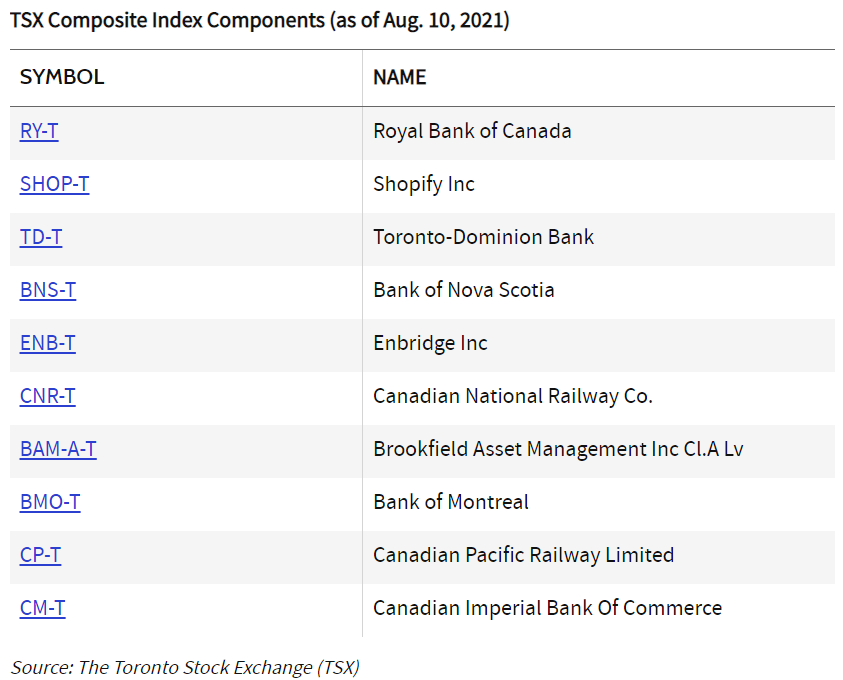

## **Основные характеристики временного ряда доходности**

Временной ряд цен закрытия индекса не является информативным ввиду инфляции. По той же причине он не может быть стационарным, а значит, с ним будет неудобно работать и многие модели, рассмотренные в данном проекте, вовсе не могут быть применены к нему.

Поэтому мы будем работать с рядом доходностей индекса, который не зависит от времени, то есть является стационарным. Будем рассматривать простые доходности, которые вычисляются по формуле ниже:

$$R_t = {\frac{P_t - P_{t-1}}{P_{t-1}}},$$

где $P_{t}$ - цена в момент t.

Загрузим данные и посмотрим на доходности S&P/TSX Composite Index за период с 1979 года по 2021 год.

Данные возьмем с сайта finance.yahoo.com.

In [ ]:
# подключим диск, на котором хранится файл с данными
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# pip install arch

In [ ]:
# импортируем библиотеки, которые будем использовать
import warnings

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot_2samples
from arch import arch_model

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
# скачаем данные и реверсируем их, т.е. расположим строки в порядке от более новых к более старым
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/прошлые данные S&P_TSX Composite.csv')
data = data.iloc[::-1].reset_index(drop=True)

In [ ]:
# напечатаем первые 5 строчек
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-31,21253.300781,21276.500000,21168.699219,21222.800781,21222.800781,1.283846e+10
1,2021-12-30,21339.099609,21433.900391,21293.400391,21294.599609,21294.599609,1.457274e+10
2,2021-12-29,21276.400391,21430.599609,21276.400391,21344.699219,21344.699219,2.338710e+10
3,2021-12-24,21233.900391,21270.199219,21229.599609,21229.699219,21229.699219,4.052060e+09
4,2021-12-23,21118.199219,21265.800781,21112.599609,21218.900391,21218.900391,2.108720e+10


In [ ]:
# нас интересуют столбцы с датой и значением цены закрытия, сохраним их в переменную daily_close
daily_close = data[['Date', 'Adj Close']]

# вычислим простые доходности с помощью фцнкции .pct_change()
daily_return = pd.concat([daily_close['Date'], daily_close['Adj Close'].pct_change()], axis=1)
daily_return.fillna(0, inplace=True)
daily_return.rename(columns={'Adj Close':'Daily return'}, inplace=True)

In [ ]:
# напечатаем полученные доходности для последних 5 дней из рассматриваемого периода
daily_return.head()

,Date,Daily return
0,2021-12-31,0.000000
1,2021-12-30,0.003383
2,2021-12-29,0.002353
3,2021-12-24,-0.005388
4,2021-12-23,-0.000509


In [ ]:
# посмотрим на типы столбцов DataFrame'а
daily_return.dtypes

Date             object
Daily return    float64
dtype: object

In [ ]:
# столбец Date имеет тип object, поменяем его на datetime, так с ним будет удобнее работать
daily_return['Date'] = pd.to_datetime(daily_return['Date'], dayfirst=True)

In [ ]:
daily_return.dtypes

Date            datetime64[ns]
Daily return           float64
dtype: object

In [ ]:
# daily_return.set_index('Date', inplace=True)

Теперь у нас есть временной ряд доходности, с которым мы можем работать.

Для начала построим график:

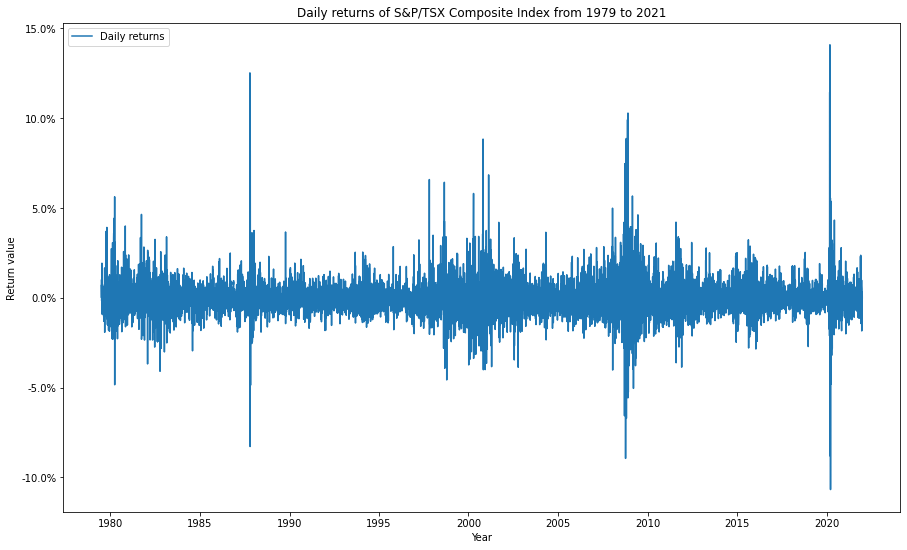

In [ ]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
plot = ax.plot(daily_return['Date'], daily_return['Daily return'] * 100, label='Daily returns')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Year')
plt.ylabel('Return value')
plt.title('Daily returns of S&P/TSX Composite Index from 1979 to 2021')
plt.legend()
plt.show()

# https://stackoverflow.com/questions/48376000/matplotlib-plotting-attributeerror-list-object-has-no-attribute-xaxis

На графике выше наблюдается высокая волатильность в 1988 году, 2000-х годах, 2008 и 2020 годах, среди прочих.

Это может быть связано со следующими событиями:

Канадская экономика испытывала слабость с начала 1980 г. до конца 1983 г., с низкими годовыми темпами роста реального ВВП на уровне 2,1% и 2,6% в 1980 и 1983 гг., соответственно, и резким падением реального ВВП на 3,2% в 1982 г., а в начале 1980-х годов у Канады было два отдельных экономических спада.

В 1988 г. Канада вступила в «большую семерку». Также с 13 по 28 февраля 1988 года в Канаде проходили XV зимние Олимпийские игры, ставшие первыми в истории этой страны.

22 октября во время экономический кризис 2008 года луни, или канадский доллар, упал ниже 80 долларов США впервые с середины 2005 года.

Во II квартале 2020 года экономика Канады сократилась на рекордные 11,5% относительно предыдущего квартала и вошла в рецессию из-за коронавируса. В годовом измерении ВВП Канады в апреле-июне рухнул на 38,7%, и это тоже рекорд.

Длительные периоды высокой волатильности обычно связаны с большой неопределенностью в реальной экономике.

Посмотрим на подборку сводных статистических данных по ежедневной доходности S&P/TSX Composite Index с 1979 по 2021 год.

In [ ]:
statistics = pd.Series({'Mean': str(round(daily_return['Daily return'].mean() * 100, 3)) + '%',
                        'Standard deviation': str(round(daily_return['Daily return'].std() * 100, 2)) + '%',
                        'Min': str(round(daily_return['Daily return'].min() * 100, 1)) + '%',
                        'Max': str(round(daily_return['Daily return'].max() * 100, 1)) + '%',
                        'Skewness': round(daily_return['Daily return'].skew(), 1),
                        'Kurtosis': round(daily_return['Daily return'].kurtosis(), 1),
                        'Autocorrelation (one lag) of returns': str(round(daily_return['Daily return'].autocorr(lag=1) * 100, 1)) + '%',
                        'Autocorrelation (one lag) of squared returns': str(round(np.sqrt(daily_return['Daily return']).autocorr(lag=1) * 100, 1)) + '%',
                        'Jarque-Bera (p-value)': str(round(stats.jarque_bera(daily_return['Daily return'])[1]  * 100, 1)) + '%', # pvalue
                        'Ljung-Box 20 lags (p-value)': str(round(sm.stats.acorr_ljungbox(daily_return['Daily return'], lags=[20]).iloc[0, 1]  * 100, 1)) + '%',
                        'Ljung-Box squared returns 20 lags (p-value)': str(float(sm.stats.acorr_ljungbox(np.sqrt(daily_return['Daily return']), lags=[20]).apply(
                            lambda x: 0 if np.isnan(x[1]) else x[1], axis=1).item())) + '%'
                        })

In [ ]:
# fig = plt.figure(figsize = (8, 3))
# ax = fig.add_subplot(111)

# statistics = pd.DataFrame(statistics, columns={''})

# ax.table(cellText = statistics.values,
#           rowLabels = statistics.index,
#           colWidths = [0.2]*len(statistics.values),
#           # colLabels = statistics.columns,
#           cellLoc = 'center',
#           loc='right'
#          )
# ax.set_title('A selection of summary statistics for daily S&P/TSX Composite Index returns from 1979 to 2021')
# # ax.title.set_size(15)
# ax.axis("off")
# plt.show()

In [ ]:
statistics = pd.DataFrame(statistics, columns={''})

print('A selection of summary statistics for daily S&P/TSX Composite Index returns from 1979 to 2021')
statistics

A selection of summary statistics for daily S&P/TSX Composite Index returns from 1979 to 2021


,
Mean,-0.019%
Standard deviation,0.98%
Min,-10.7%
Max,14.1%
Skewness,1.4
Kurtosis,21.4
Autocorrelation (one lag) of returns,3.4%
Autocorrelation (one lag) of squared returns,23.9%
Jarque-Bera (p-value),0.0%
Ljung-Box 20 lags (p-value),0.0%


Среднее значение дневной доходности не просто мало, но даже отрицательно, и составляет -0.019%, дневная волатильность составляет около 0.98%.

Самая низкая дневная доходность в -10.7%, ровно как и самая высокая в 14%, соответствует экономическим последствиям короновируса в 2020 году.

Доходности имеют небольшую положительную асимметрию и, что более важно, довольно высокий эксцесс.

Наконец, дневная доходность имеет автокорреляцию около 3%, в то время как квадрат доходности, являющийся показателем волатильности, имеет автокорреляцию почти 24%, что дает очень убедительные доказательства предсказуемости волатильности и кластеров волатильности.

В таблице также приведены результаты теста на нормальность Жака-Бера (Jarque–Bera (JB) test) и теста на наличие автокорреляции (до 20 лагов) Льюинга-Бокса (Ljung–Box (LB) test).

## **Волатильность доходности**

Волатильность является наиболее распространенной мерой неопределенности рынка.

Рассчитаем волатильность в подпериодах данных по ежедневной доходности S&P/TSX Composite Index.

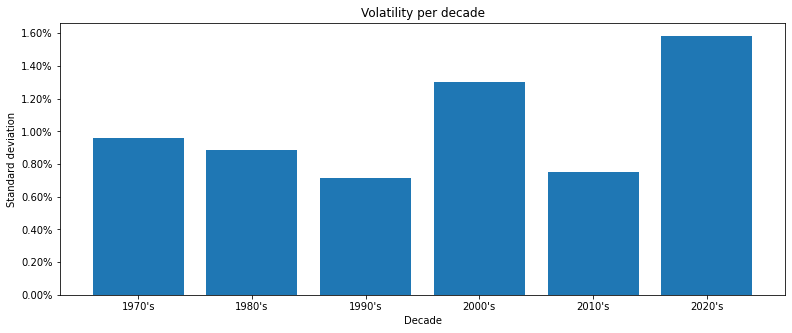

In [ ]:
# group daily returns by decade
stds = daily_return.groupby((daily_return['Date'].dt.year // 10) * 10)['Daily return'].std()

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(111)
plot = ax.bar(pd.Series(stds.index.values).apply(lambda x: str(x) + "'s"), stds.values * 100)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Decade')
plt.ylabel('Standard deviation')
plt.title('Volatility per decade')
plt.show()

На рисунка выше показана волатильность по десятилетиям с 1979 по 2020 года, и можно увидеть явные свидетельства циклических закономерностей волатильности от одного десятилетия к другому.

Волатильность была самой низкой в 1990-х и 2010-х годах и самой высокой во время эпидемиологической ситуации, связанной с коронавирусной инфекцией, в 2020-х годах.

Обратите внимание, что значения 2020-х годов содержат только два года (2020 и 2021).

Посмотрим теперь на волатильность доходности рассматриваемого индекса в разрезе лет.

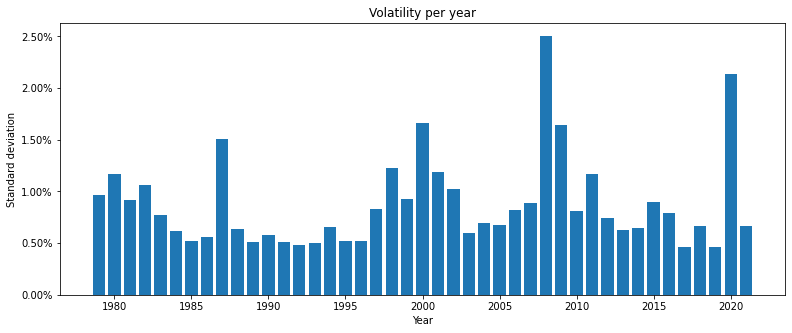

In [ ]:
# group daily returns by year
stds = daily_return.groupby(daily_return['Date'].dt.year)['Daily return'].std()

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(111)
plot = ax.bar(stds.index.values, stds.values * 100)
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Year')
plt.ylabel('Standard deviation')
plt.title('Volatility per year')
plt.show()

Самыми нестабильными являются 2008 и 2020 года, т.е. периоды экономического кризиса и распространения коронавирусной инфекции, соответственно.

Самые спокойные года — 2017 и 2019, как раз перед эпидемией, вспыхнувшей в 2020 году; 1991–1993 года тоже достаточно спокойные.

Однако тот факт, что волатильность была низкой в эти периоды, не означает, что риск на финансовых рынках в те годы был низким, поскольку волатильность может быть низкой, когда хвосты толстые.

Другими словами, переменная с низкой волатильностью может иметь гораздо более экстремальные результаты, чем другая переменная с более высокой волатильностью. Вот почему волатильность является вводящей в заблуждение мерой риска.

Наконец, взглянем на среднюю дневную волатильность в разрезе месяцев в период с 1979 по 2021 года.

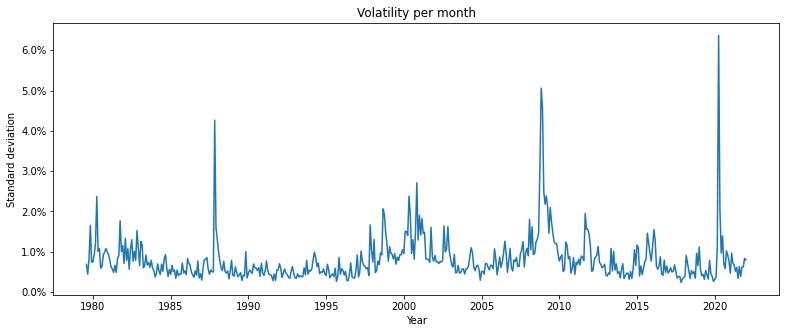

In [ ]:
# group daily returns by year and month
stds = daily_return.set_index('Date').groupby(pd.Grouper(freq="M"))['Daily return'].std()

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(111)
plot = ax.plot(stds.index.values, stds.values * 100)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Year')
plt.ylabel('Standard deviation')
plt.title('Volatility per month')
plt.show()

И снова видно, что волатильность имела тенденцию к снижению и была очень низкой во втором квартале 1990-х и 2017-2019 годах. Ситуация меняется в результате кризиса 2008 года, а также событий 2020 года.

Взятые вместе, цифры дают убедительные доказательства того, что существуют как долгосрочные циклы волатильности, охватывающие десятилетия, так и короткие циклы, охватывающие недели или месяцы.

В этом случае мы наблюдаем циклы внутри циклов внутри циклов.

## **Кластеры волатильности**

Смотря на графики волатильности выше, становится очевидным, что она меняется со временем.

Кроме того, учитывая очевидные циклы, волатильность частично предсказуема.

Эти явления известны как кластеры волатильности.

Посмотрим на функцию автокорреляции (autocorrelation function (ACF)), которая измеряет, как доходность за один день коррелирует с доходностью в предыдущие дни. Если такие корреляции статистически значимы, у нас есть веские доказательства предсказуемости.

In [ ]:
from pandas.plotting import autocorrelation_plot

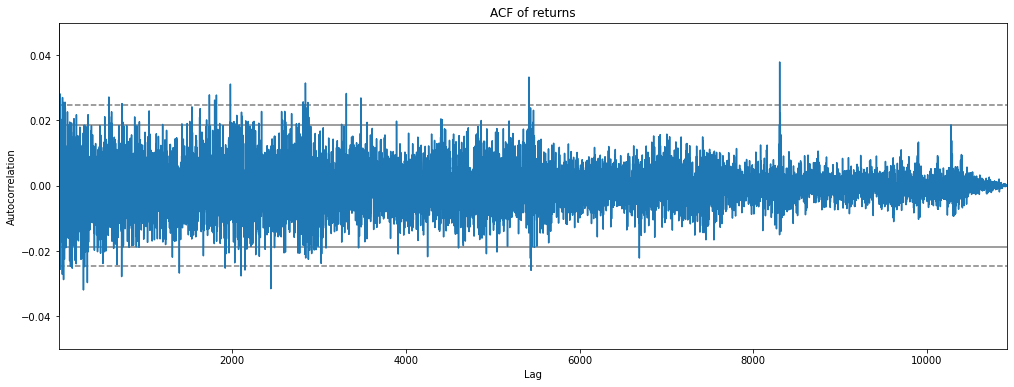

In [ ]:
plt.figure(figsize=(17, 6))

autocorrelation_plot(daily_return['Daily return'])

plt.ylim(-0.05, 0.05)
plt.title('ACF of returns')
plt.grid(False)
plt.show()

Итак, мы построили график автокорреляции дневных доходностей S&P/TSX Composite Index в рассматриваемый период.

Горизонтальные сплошная и пунктирная линии на графике соответствуют 95% и 99% доверительным интервалам.

Видна низкая автокорреляция, но есть выбросы, что удовлетворяет гипотезе, согласно которой в спокойные периоды автокорреляция низкая, а когда происходят катастрофические события, автокорреляция начинает возрастать.

Сравним полученную ACF с ACF квадратов доходностей на графике ниже (с теми же доверительными интервалами), где она значима даже при длительных лагах, предоставляя убедительные доказательства предсказуемости волатильности.

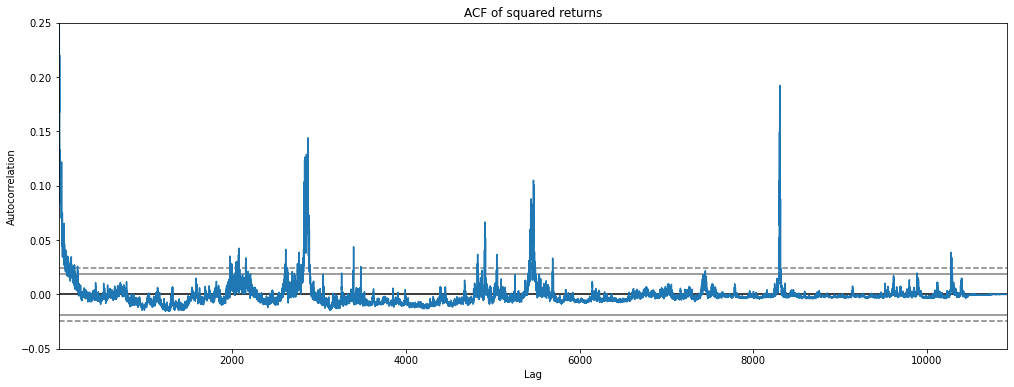

In [ ]:
plt.figure(figsize=(17, 6))

autocorrelation_plot(daily_return['Daily return'] ** 2)

plt.ylim(-0.05, 0.25)
plt.title('ACF of squared returns')
plt.grid(False)
plt.show()

Мы можем проверить совместную значимость коэффициентов автокорреляции для нескольких лагов, используя тест Льюинга-Бокса (Ljung–Box (LB) test).

Тест Льюинга-Бокса — это статистический тест, который проверяет наличие автокорреляции во временном ряду.

В этом тесте проверяются следующие гипотезы:

$H_0$: остатки распределяются независимо.

$H_A$: остатки не распределяются независимо, они демонстрируют корреляцию.

В идеале мы хотели бы не отвергать нулевую гипотезу. То есть мы хотели бы, чтобы p-значение (p-value) теста было больше 0,05, потому что это означало бы, что остатки для нашей модели временных рядов независимы, что часто является предположением, которое мы делаем при создании модели.

Проведем тест, используя 21 лаг дневной доходности S&P/TSX Composite Index.

Тест выполняется с использованием полного размера выборки, а также последних 2500 и 100 наблюдений. Результаты приведены в таблице ниже:

In [ ]:
lb = pd.DataFrame({
    'T': [],
    'Ljung–Box test, 21 lags': [],
    'p-value': []
})

In [ ]:
for _, num in enumerate([daily_return.shape[0], 1000, 100]):
  lb_test = sm.stats.acorr_ljungbox(daily_return['Daily return'].iloc[-num:], lags=[21])
  lb_start, lb_pvalue = lb_test[0][0], lb_test[1][0]
  lb = lb.append({'T': np.array(num),
                  'Ljung–Box test, 21 lags': round(lb_start, 1),
                  'p-value': round(lb_pvalue, 1)},
                 ignore_index=True)

In [ ]:
lb

,T,"Ljung–Box test, 21 lags",p-value
0,10924,104.2,0.0
1,1000,90.7,0.0
2,100,24.8,0.3


Тестовая статистика теста для всей выборки составляет 104.2, а p-значение теста составляет 0.0, что намного меньше 0.05. Таким образом, мы еще раз отвергаем нулевую гипотезу теста и заключаем, что остатки не являются независимыми.

Повторим ту же процедуру для квадратов доходностей индекса:

In [ ]:
lb2 = pd.DataFrame({
    'T': [],
    'Ljung–Box test, 21 lags': [],
    'p-value': []
})

for _, num in enumerate([daily_return.shape[0], 1000, 100]):
  lb_test = sm.stats.acorr_ljungbox((daily_return['Daily return'] ** 2).iloc[-num:], lags=[21])
  lb_start, lb_pvalue = lb_test[0][0], lb_test[1][0]
  lb2 = lb2.append({'T': np.array(num),
                   'Ljung–Box test, 21 lags': round(lb_start, 1),
                   'p-value': round(lb_pvalue, 1)},
                  ignore_index=True)

In [ ]:
lb2

,T,"Ljung–Box test, 21 lags",p-value
0,10924,10205.7,0.0
1,1000,163.4,0.0
2,100,28.7,0.1


Причина сосредоточения внимания на квадратах доходностей заключается в том, что они являются косвенными показателями волатильности.

p-значение (p-value) для наименьшего размера выборки квадратов доходности намного ниже, чем соответствующее значение для выборки доходностей.

Таким образом, таблицы выше еще раз показывают, что прогнозировать волатильность легче, чем доходность.

## **Ненормальность и жирные хвосты**

Под ненормальностью мы будем понимать отсутствие нормального распределения.

Часто при анализе финансовых рисков предполагается, что доходности индекса распределяются нормально.

Посмотрим на доходности и вероятности ежедневной доходности S&P/TSX Composite Index при условии нормальности.

In [ ]:
returns = [1, 2, 3, 5, 11, 14]

# PDF для нормального распределения с такими же средним и дисперсией, как у ряда доходности индекса
probabilities = stats.norm.pdf(returns,
                               loc=daily_return['Daily return'].mean() * 100,
                               scale=daily_return['Daily return'].std() * 100)

# 0.23715262, 0.048907743, 0.0035668696, 0.00000083904679, ...

normal_pdf = pd.DataFrame({'Return': returns,
                           'Probability': probabilities})

normal_pdf['Return'] = normal_pdf['Return'].apply(lambda x: str(x) + '%')

In [ ]:
normal_pdf

,Return,Probability
0,1%,2.371526e-01
1,2%,4.890774e-02
2,3%,3.566870e-03
3,5%,8.390468e-07
4,11%,1.598530e-28
5,14%,1.775199e-45


Из приведенной в самом начале статистики видно, что самое большое однодневное падение индекса составило 11% (10.7%), в то время как самое большое поднятие индекса равнялось 14% (14.1%).

Если бы ряд доходностей S&P/TSX Composite Index действительно был нормально распределен, вероятности этих однодневных краха и пика были бы ${1.6 * 10^{-28}}$ и ${1.7 * 10^{-45}}$, соответственно, согласно таблице выше.

Другими словами, такое крушение должно происходить раз в ${10^{-28}}$ лет, а подобное поднятие - раз в ${10^{-45}}$ лет (с учетом выходных и праздников).

Чтобы поместить это в контекст, ученые обычно предполагают, что Земле около ${10^{-7}}$ лет, а Вселенной ${10^{-13}}$ лет.

Таким образом, предполагая нормальность, мы утверждаем, что крах 2020 года происходит лишь в каждой второй вселенной, тем временем, достижение доходности в 14%, как это произошло в том же 2020 году, случается только в одной из каждых 3 вселенных.

Тем не менее, можно утверждать, что поднятие 2020 года, как и крах, было аномалией, поэтому допущение нормальности для всех остальных дней было бы относительно безобидным.

Поэтому взглянем на самые экстремальные значения дневной доходности индекса в разрезе отдельных десятилетий и годов, соответственно.

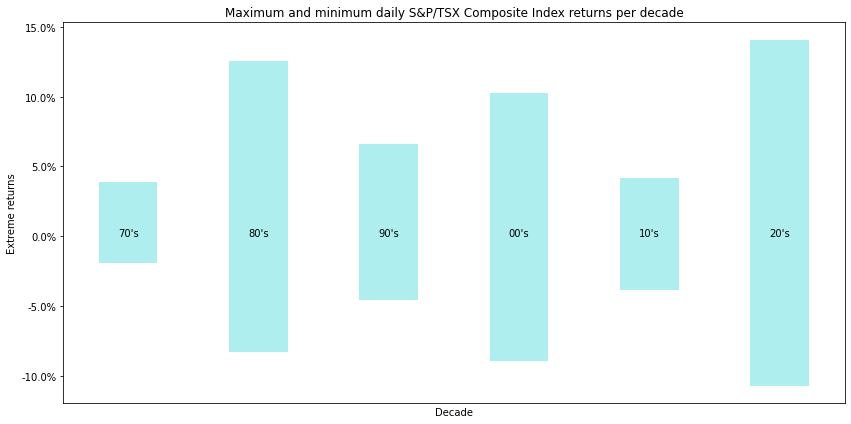

In [ ]:
# group daily returns by decade
extremes = daily_return.groupby((daily_return['Date'].dt.year // 10) * 10).agg({'Daily return': ['min', 'max']})
labels = pd.Series(extremes.index).apply(lambda x: str(x)[-2:] + "'s")

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
plot1 = ax.bar(extremes.index, extremes[('Daily return', 'max')] * 100, width=4.5, color='paleturquoise')
plot2 = ax.bar(extremes.index, extremes[('Daily return', 'min')] * 100, width=4.5, color='paleturquoise')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xticks([]) # чтобы убрать значения по оси х
plt.xlabel('Decade')
plt.ylabel('Extreme returns')
plt.title('Maximum and minimum daily S&P/TSX Composite Index returns per decade')

for i in range(len(labels)):
        plt.text(extremes.index[i], 0, labels[i], ha = 'center')

plt.show()

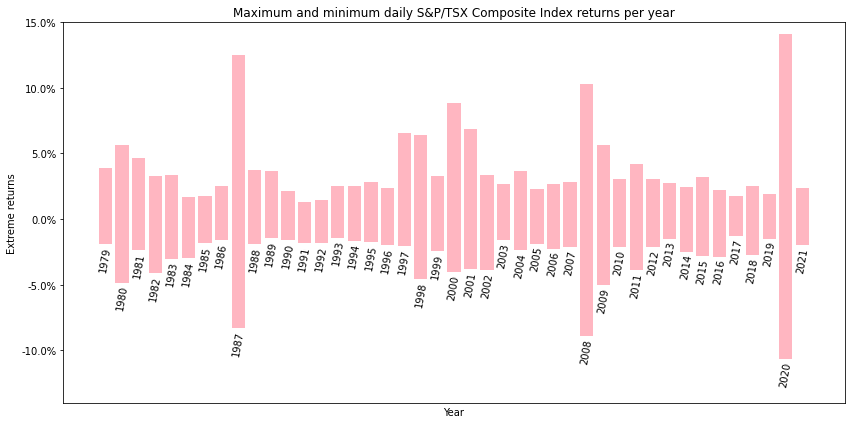

In [ ]:
# group daily returns by year
extremes = daily_return.groupby(daily_return['Date'].dt.year).agg({'Daily return': ['min', 'max']})

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
plot1 = ax.bar(extremes.index, extremes[('Daily return', 'max')] * 100, width=0.8, color='lightpink')
plot2 = ax.bar(extremes.index, extremes[('Daily return', 'min')] * 100, width=0.8, color='lightpink')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xticks([])
plt.ylim([-14, 15])
plt.xlabel('Year')
plt.ylabel('Extreme returns')
plt.title('Maximum and minimum daily S&P/TSX Composite Index returns per year')

for i in range(len(extremes.index)):
        plt.text(extremes.index[i], extremes[('Daily return', 'min')].iloc[i] * 100 - 2, extremes.index[i], rotation=80, ha = 'center')

plt.show()

Из приведенных выше графиков видно, что экстремумов гораздо больше, чем предсказывает таблица, соответствующая перцентилям нормального распределения.

Воспользуемся альтернативным способом анализа распределения доходностей S&P/TSX Composite Index:

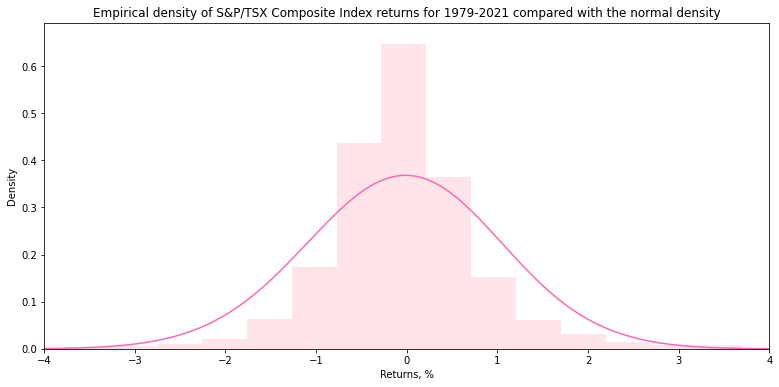

In [ ]:
fig = plt.figure(figsize=(13, 6))

# сгенерируем выборку из нормального распределения
norm_data = np.random.normal(loc=daily_return['Daily return'].mean() * 100,
                             scale=daily_return['Daily return'].std() * 100,
                             size=daily_return.shape[0])

# построим ее плотность
sns.kdeplot(norm_data, bw = 0.5, color='hotpink')

sns.distplot(daily_return['Daily return'] * 100, hist=True, kde=True,
            hist_kws={'color': 'pink'},
            kde_kws={'color': 'orange', 'lw': 0})

plt.xlim([-4, 4])
plt.xlabel('Returns, %')
plt.ylabel('Density')
plt.title('Empirical density of S&P/TSX Composite Index returns for 1979-2021 compared with the normal density')

plt.show()

На графике выше построена гистограмма доходности (в %), на которую наложено нормальное распределение с теми же средним значением и дисперсией.

Для удобства хвосты обрезаны на уровне 4%.

Посмотрим также на нормальное распределение и эмпирическое распределение доходности индекса:

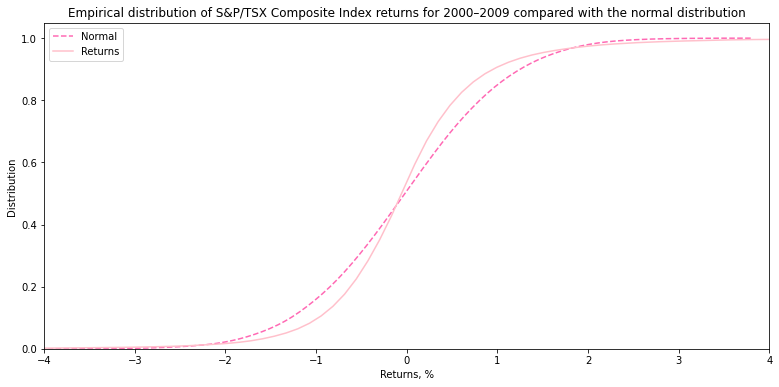

In [ ]:
fig = plt.figure(figsize=(13, 6))

sns.distplot(norm_data, hist=False, kde=True,
            label='Normal',
            kde_kws={'color': 'hotpink', 'linestyle':'--', 'cumulative': True})

sns.distplot(daily_return['Daily return'] * 100, hist=False, kde=True,
            label='Returns',
            kde_kws={'color': 'pink', 'cumulative': True})

plt.xlim([-4, 4])
plt.xlabel('Returns, %')
plt.ylabel('Distribution')
plt.title('Empirical distribution of S&P/TSX Composite Index returns for 1979-2021 compared with the normal distribution')
plt.legend()

plt.show()

Увеличим левый хвост распределения:

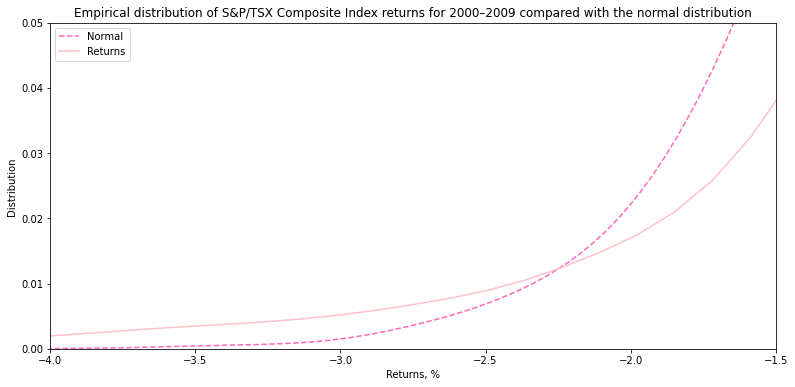

In [ ]:
fig = plt.figure(figsize=(13, 6))

sns.distplot(norm_data, hist=False, kde=True,
            label='Normal',
            kde_kws={'color': 'hotpink', 'linestyle':'--', 'cumulative': True})

sns.distplot(daily_return['Daily return'] * 100, hist=False, kde=True,
            label='Returns',
            kde_kws={'color': 'pink', 'cumulative': True})

plt.xlim([-4, -1.5])
plt.ylim([0, 0.05])
plt.xlabel('Returns, %')
plt.ylabel('Distribution')
plt.title('Empirical distribution of S&P/TSX Composite Index returns for 1979-2021 compared with the normal distribution')
plt.legend()

plt.show()

Итого, мы можем сделать следующие выводы:

1. Пик распределения доходностей индекса намного выше, чем для нормального распределения.

2. Стороны распределения доходностей индекса ниже, чем у нормального распределения.

3. Хвосты распределения доходностей индекса намного толще, чем у нормального распределения.

Другими словами, существует больше дней, когда на рынке происходит очень мало, чем предсказывается нормальным распределением, и больше дней, когда рыночные цены значительно меняются.

## **Идентификация толстых хвостов**

Как мы только что убедились, доходности индекса демонстрируют то, что известно как толстые хвосты.

Как уже было замечено, говорят, что случайная величина имеет толстые хвосты, если она показывает более экстремальные результаты, чем нормально распределенная случайная величина с теми же средним значением и дисперсией.

Это означает, что рынок имеет больше относительно больших и малых результатов, чем можно было бы ожидать при нормальном распределении, и, наоборот, меньше доходов промежуточной величины.

В частности, вероятность больших результатов намного выше, чем можно было бы предсказать для нормально распределенной величины.

### **Статистические тесты для определения толстых хвостов**

Коэффициент асимметрии — величина, характеризующая асимметрию распределения вероятностей случайной величины.

Эксцесс — степень остроконечности распределения по отношению к хвостам.

Высокий эксцесс обычно означает, что большая часть дисперсии обусловлена ​​нечастыми экстремальными отклонениями, чем предсказывается нормой, и является сильным, но не идеальным признаком того, что ряд возвратов имеет толстые хвосты.

Эксцесс свыше 3 считается избыточным. Таким образом, быстрый, но, конечно, не самый надежный тест на толстые хвосты состоит в том, чтобы увидеть, превышает ли эксцесс 3.

Вспомним, что значение эксцесса в таблице со всей основной статистикой равно 21 (21.4), что является довольно веским доказательством против нормальности. При этом асимметрия составляет 1.4, в то время как третий момент нормального распределения всегда равен 0, по чему также можно судить о ненормальности распределения временного ряда.

Если говорить о более "официальных" тестах в этой категории, распространенным является тест Жака-Бера (Jarque–Bera (JB) test), значение которого мы также считали вначале.

Этот тест проверяет ошибки наблюдений (в нашем случае, дневные доходности индекса) на нормальность посредством сверки их третьего момента (асимметрия) и четвёртого момента (эксцесс) с моментами нормального распределения, у которого $S=0, K=3$.

В тесте Жака—Бера проверяется нулевая гипотеза $H_0: S=0, K=0$ против гипотезы $H_1: S \neq 0, K \neq 0$, где $S$ — коэффициент асимметрии (Skewness),  $K$ — коэффициент эксцесса (Kurtosis).

Чем ближе распределение ошибок к нормальному, тем меньше статистика Жака—Бера отличается от нуля. При достаточно большом значении статистики p-value будет мало, и тогда будет основание отвергнуть нулевую гипотезу (статистика попала в «хвост» распределения).

Для S&P/TSX Composite Index p-value принимает значение 0, что еще раз подтверждает ненормальность распределения доходностей индекса.

Другим распространенным тестом на нормальность является тест Колмогорова-Смирнова (Kolmogorov–Smirnov test (KS)), который основан на оценке минимального расстояния, сравнивающей выборку с эталонным распределением вероятностей (например, с нормальным распределением).

Преимущество теста KS заключается в том, что он не делает никаких предположений о распределении данных, за исключением непрерывности обеих функций распределения (т. е. с технической точки зрения, он непараметричен и не зависит от распределения).

Иногда утверждают, что тест KS более мощный, чем тест JB, потому что он рассматривает все распределение.

Тест KS чувствителен к различиям как в расположении, так и в форме кумулятивной функции распределения, и на практике требуется относительно большое количество наблюдений, чтобы отклонить нулевую гипотезу.

Однако в большинстве случаев тесты KS и JB совпадают.

Проведем такой тест для индекса и получим:

In [ ]:
print(stats.kstest(daily_return['Daily return'], 'norm')[1], '%')

0.0 %


Таким образом, в нашем случае значения тестов действительно совпадают.

### **Графические методы анализа жирных хвостов**

Возможно, наиболее часто используемым графическим методом для анализа хвостов распределений является QQ plot (quantile–quantile plot).

График квантиль-квантиль используют для оценки того, имеет ли набор наблюдений определенное распределение или два набора данных имеют одинаковое распределение.

QQ plot сравнивает квантили выборочных данных с квантилями эталонного распределения, таким образом, при его использовании оценивается, имеет ли набор выборочных наблюдений то же распределение.

Посмотрим на QQ plot для S&P/TSX Composite Index по сравнению с нормальным распределением:

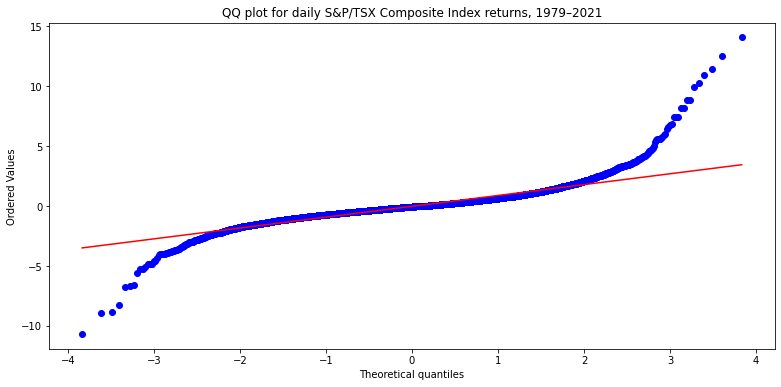

In [ ]:
import pylab

fig = plt.figure(figsize=(13, 6))

stats.probplot(daily_return['Daily return'] * 100, dist="norm", plot=pylab)

plt.title('QQ plot for daily S&P/TSX Composite Index returns, 1979–2021')

pylab.show()
# plt.show()

Прямая линия — это нормальный прогноз.

Из QQ plot'а выше видно, что многие наблюдения, кажется, отклоняются от нормальности, как в минус, так и в плюс, поскольку график QQ имеет четкую S-образную форму.

Хвосты у доходностей кажутся более толстыми, чем у нормального распределения. Мы можем получить некоторое представление об упитанности хвоста, сравнивая данные по индексу с распределением с толстыми хвостами.

Например, распределение Стьюдента-t имеет толстые хвосты, где степени свободы указывают, насколько толстыми на самом деле являются эти хвосты.

На графике ниже распределение Стьюдента с 5 степенями свободы, t(5), выбрано в качестве эталонного распределения.

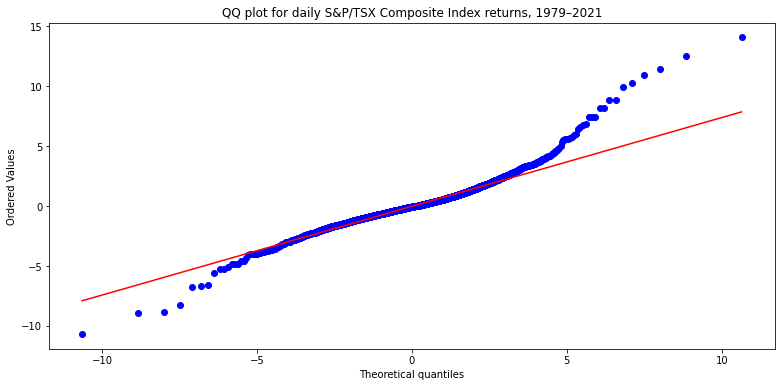

In [ ]:
fig = plt.figure(figsize=(13, 6))

stats.probplot(daily_return['Daily return'] * 100,
               dist=stats.t, sparams=(5, ), plot=pylab)

plt.title('QQ plot for daily S&P/TSX Composite Index returns, 1979–2021')

pylab.show()
# plt.show()

Доходности явно кажутся высокими по сравнению со Student-5 как с нижней, так и с верхней стороны. Посмотрим на соответствующие графики для t(4) и t(3):

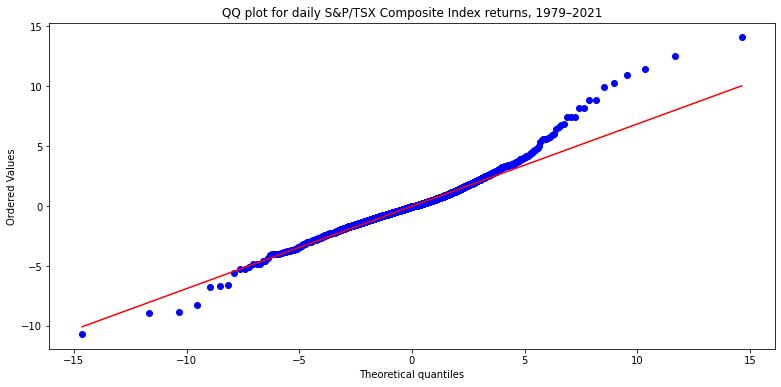

In [ ]:
fig = plt.figure(figsize=(13, 6))

stats.probplot(daily_return['Daily return'] * 100,
               dist=stats.t, sparams=(4, ), plot=pylab)

plt.title('QQ plot for daily S&P/TSX Composite Index returns, 1979–2021')

pylab.show()
# plt.show()

Кажется, что данные становятся ближе, нижняя сторона примерно соответствует t(4), в то время как верхняя сторона все еще довольно жирная.

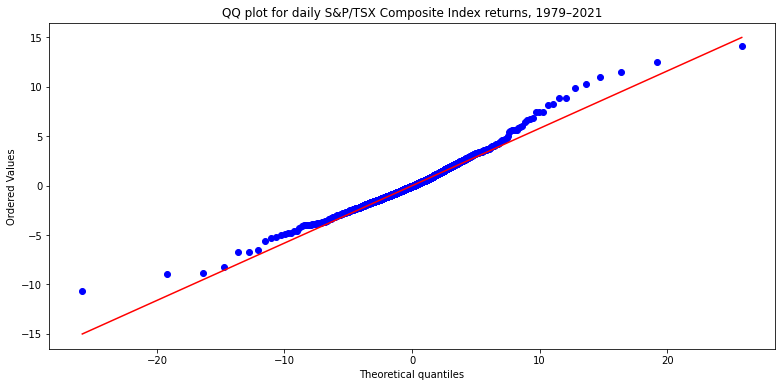

In [ ]:
fig = plt.figure(figsize=(13, 6))

stats.probplot(daily_return['Daily return'] * 100,
               dist=stats.t, sparams=(3, ), plot=pylab)

plt.title('QQ plot for daily S&P/TSX Composite Index returns, 1979–2021')

pylab.show()
# plt.show()

Однако, из графика для t(3) мы видим, что данные больше соответствуют Student-3, как с верхней, так и с нижней стороны.

Вывод состоит в том, что доходность S&P/TSX Composite Index имеет хвосты, приблизительно равные t(3), где верхний хвост кажется немного толще нижнего.

Альтернативным графическим методом обнаружения толстых хвостов является график последовательных моментов, в основе которого лежит теория экстремальных значений.

Здесь толщина хвоста распределения измеряется индексом хвоста, обозначенным $l$. Чем ниже этот индекс, тем толще хвосты.

В частном случае распределения Стьюдента-t хвостовой индекс соответствует степеням свободы.

Таким образом, этот простой графический метод проверяет толщину хвоста с использованием выборочных моментов данных. Для этого вычисляется $m$-й центральный момент, который определяется выражением:

$$ E[(X - {\mu})^m] = \int_{-\infty}^{\infty} (x - {\mu})^m f(x)dx $$

Этот интеграл не имеет конечного решения для всех m и всех распределений. В частности, если распределение имеет толстый хвост, мы можем вычислить моменты только для $m < l$.

Из этого следует, что если число моментов, которые мы можем вычислить, конечно (т. е. мы не можем вычислить моменты для всех $m > 0$), данные должны иметь толстые хвосты.

В случае нормального распределения имеем $l={\infty}$, а значит, можем вычислить все моменты.

Таким образом, мы можем измерить толщину хвостов, графически отображая моменты набора данных по мере добавления все большего количества наблюдений:

$$ \frac{1}{t} \sum_{i = 1}^{t} x_t^m $$

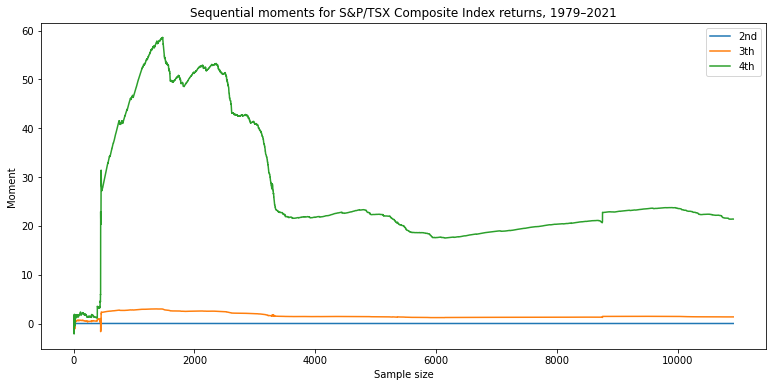

In [ ]:
# посчитаем 2, 3 и 4 моменты
vars = pd.Series(daily_return.index).apply(lambda x: daily_return['Daily return'].iloc[:x + 1].std())
skewnesses = pd.Series(daily_return.index).apply(lambda x: daily_return['Daily return'].iloc[:x + 1].skew())
kurtosises = pd.Series(daily_return.index).apply(lambda x: daily_return['Daily return'].iloc[:x + 1].kurtosis())

fig = plt.figure(figsize=(13, 6))

plt.plot(daily_return.index, vars, label='2nd')
plt.plot(daily_return.index, skewnesses, label='3th')
plt.plot(daily_return.index, kurtosises, label='4th')

plt.xlabel('Sample size')
plt.ylabel('Moment')
plt.title('Sequential moments for S&P/TSX Composite Index returns, 1979–2021')
plt.legend()

plt.show()

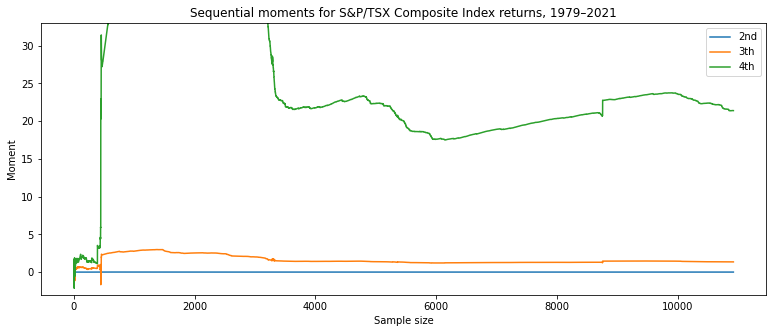

In [ ]:
# немного приблизим
fig = plt.figure(figsize=(13, 5))

plt.plot(daily_return.index, vars, label='2nd')
plt.plot(daily_return.index, skewnesses, label='3th')
plt.plot(daily_return.index, kurtosises, label='4th')

plt.ylim([-3, 33])
plt.xlabel('Sample size')
plt.ylabel('Moment')
plt.title('Sequential moments for S&P/TSX Composite Index returns, 1979–2021')
plt.legend()

plt.show()

Как и ожидалось, второй момент сходится, а вот четвертый - нет, что указывает на то, что хвостовой индекс доходности важнейшего канадского индекса находится между 2 и 4.

## **Нелинейная зависимость**

Последним стилизованным фактом финансовой доходности является нелинейная зависимость - наблюдение, что зависимость между различными рядами доходности изменяется в зависимости от рыночных условий.

Например, большую часть времени цены на активы меняются относительно независимо друг от друга, но в кризис все они падают вместе.

На практике совместные экстремальные результаты более вероятны, чем это предсказывает многомерная нормальность и линейные корреляции.

Большинство статистических моделей предполагают, что взаимосвязь между различными доходами является линейной, однако недавние исследования показали, что предположение о линейной зависимости обычно не выполняется для доходности активов, где корреляция обычно ниже на бычьих рынках, чем на медвежьих.

Кроме того, если бы финансовые данные были совместно распределены нормально, корреляции уменьшались бы для экстремальных событий, тогда как эмпирически мы видим, что корреляции имеют тенденцию увеличиваться до единицы во время кризиса, как показано ниже.

Чтобы уловить такие явления, модели нелинейной зависимости позволяют изменять структуру зависимости в зависимости от рыночных условий.

При этом линейные корреляции завышают зависимость в некризисные периоды и занижают корреляции во время кризисов.

## **Выборочное доказательство нелинейной зависимости**

Мы проиллюстрируем в данном разделе нелинейную зависимость с помощью долгосрочных корреляций между доходностями трех банков, Bank of Montreal (BMO), Royal Bank of Canada (RY) и The Toronto-Dominion Bank (TD), и одной нефинансовой фирмы Alimentation Couche-Tard Inc (ATD), специализирующейся на розничной торговле, все они являются компонентами S&P/TSX Composite Index, за период времени с 6 сентября 1996 г. по 10 декабря 2021 г.

In [ ]:
# скачаем данные по активам финансовых организаций
bmo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/BMO.csv')
ry = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/RY.csv')
td = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/TD.csv')

# скачаем данные по активу нефинансовой организации
atd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/ATD.csv')

In [ ]:
def asmodify(asset, name):
  # реверсируем данные, т.е. расположим строки в порядке от более новых к более старым
  asset = asset.iloc[::-1].reset_index(drop=True)

  # нас интересуют столбцы с датой и значением цены закрытия, сохраним только их
  asset = asset[['Date', 'Adj Close']]

  # вычислим простые доходности с помощью фцнкции .pct_change()
  asset = pd.concat([asset['Date'], asset['Adj Close'].pct_change()], axis=1)
  asset.fillna(0, inplace=True)
  asset.rename(columns={'Adj Close':name}, inplace=True)

  # столбец Date имеет тип object, поменяем его на datetime, так с ним будет удобнее работать
  asset['Date'] = pd.to_datetime(asset['Date'], dayfirst=True)

  return asset


In [ ]:
bmo = asmodify(bmo, 'BMO')
ry = asmodify(ry, 'RY')
td = asmodify(td, 'TD')
atd = asmodify(atd, 'ATD')

In [ ]:
from functools import reduce

# объединим временные ряды доходностей активов в один датафрейм
assets = [bmo, ry, td, atd]
assets = reduce(lambda  left, right: pd.merge(left, right, on=['Date'], how='inner'), assets)

In [ ]:
assets.head()

,Date,BMO,RY,TD,ATD
0,2021-12-10,0.000000,0.022995,0.011334,0.009082
1,2021-12-09,-0.006143,-0.002932,0.001334,0.049000
2,2021-12-08,0.006089,0.004607,0.005863,-0.018113
3,2021-12-07,0.001834,0.005854,-0.005961,-0.036311
4,2021-12-06,-0.010983,-0.018624,-0.013593,-0.015918


In [ ]:
# функция для подсчета коэффициента корреляции, а также доверительного интервала для него
def pearsonr_ci(x, y, alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x, y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi


  # source: https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/

Итак, взглянем на корреляции (и доверительные интервалы) ежедневных доходностей для Bank of Montreal (BMO), Royal Bank of Canada (RY), The Toronto-Dominion Bank (TD), а также Alimentation Couche-Tard Inc (ATD) за период с 6 сентября 1996 г. по 23 марта 2020 г.:

In [ ]:
# создадим пустой датафрейм
correlations_before_2020 = pd.DataFrame(index=['BMO', 'RY', 'TD', 'ATD'],
                                        columns=['BMO', 'RY', 'TD', 'ATD'])

# заполним его значениями корреляций и соответствующих им доверительных интервалов
for col in correlations_before_2020.columns:
  for ind in correlations_before_2020.index:
    r, _, lo, hi = pearsonr_ci(assets[assets['Date'] < '2020-03-23'][col],
                               assets[assets['Date'] < '2020-03-23'][ind],
                               alpha=0.05)
    r, lo, hi = round(r, 2), round(lo, 2), round(hi, 2)
    correlations_before_2020.loc[col, ind] = f'{int(r * 100)}% {(int(lo * 100), int(hi * 100))}'

# немного подправим стиль
correlations = correlations_before_2020.style.set_table_styles([{"selector":"thead",
                                                                 "props": [("font-size", "1.2rem")]},
                                                                {"selector":"th.row_heading",
                                                                 "props": [("font-size", "1rem")]}])

# source (for header style): https://coderzcolumn.com/tutorials/python/simple-guide-to-style-display-of-pandas-dataframes#2

In [ ]:
correlations_before_2020

,BMO,RY,TD,ATD
BMO,"100% (100, 100)","81% (80, 82)","79% (78, 80)","11% (9, 14)"
RY,"81% (80, 82)","100% (100, 100)","79% (79, 80)","12% (9, 14)"
TD,"79% (78, 80)","79% (79, 80)","100% (100, 100)","12% (9, 14)"
ATD,"11% (9, 14)","12% (9, 14)","12% (9, 14)","100% (100, 100)"


Как можно заметить, финансовые показатели относительно сильно коррелируют, в то время как компания, занимающаяся продуктовой розницей, коррелирует с ними совсем незначительно — около 11% (можно сказать, что и не коррелирует вовсе), и это логично.

Посмотрим, что изменится для временного промежутка с 23 марта 2020 г. по 1 апреля 2020 г., во время пика экономической нестабильности, связанной со вспышкой вируса в Канаде:

In [ ]:
# создадим пустой датафрейм
correlations_2020 = pd.DataFrame(index=['BMO', 'RY', 'TD', 'ATD'],
                                 columns=['BMO', 'RY', 'TD', 'ATD'])

# заполним его значениями корреляций и соответствующих им доверительных интервалов
for col in correlations_2020.columns:
  for ind in correlations_2020.index:
    r, _, lo, hi = pearsonr_ci(assets[(assets['Date'] >= '2020-03-23') & (assets['Date'] <= '2020-04-01')][col],
                               assets[(assets['Date'] >= '2020-03-23') & (assets['Date'] <= '2020-04-01')][ind],
                               alpha=0.05)
    r, lo, hi = round(r, 2), round(lo, 2), round(hi, 2)
    correlations_2020.loc[ind, col] = f'{int(r * 100)}% {(int(lo * 100), int(hi * 100))}'

# немного подправим стиль
correlations_2020 = correlations_2020.style.set_table_styles([{"selector":"thead",
                                                               "props": [("font-size", "1.2rem")]},
                                                              {"selector":"th.row_heading",
                                                               "props": [("font-size", "1rem")]}])

In [ ]:
correlations_2020

,BMO,RY,TD,ATD
BMO,"100% (100, 100)","99% (92, 100)","98% (91, 100)","74% (7, 95)"
RY,"99% (92, 100)","100% (100, 100)","100% (98, 100)","79% (19, 96)"
TD,"98% (91, 100)","100% (98, 100)","100% (100, 100)","77% (14, 96)"
ATD,"74% (7, 95)","79% (19, 96)","77% (14, 96)","100% (100, 100)"


Мы видим, что корреляция активов резко и значительно возросла. Например, если судить по таблице выше, корреляция между доходностями Royal Bank of Canada (RY) и The Toronto-Dominion Bank (TD) увеличилась с 79% до 100%, с доверительным интервалом (98%, 100%), что важно иметь в виду.

Такая высокая корреляция указывает на то, что акции двух компаний движутся не просто почти синхронно, а буквально шаг в шаг.

Существенный рост коэффициентов корреляции затронул также Alimentation Couche-Tard Inc (ATD), чья деятельность никак не связана с банковским сектором. Корреляции этой компании с финансовыми организациями выросли в несколько раз.

Кроме того, в таблице ниже показано, как период экономической нестабильности повлиял на фактические цены (доходности) акций:

In [ ]:
# создадим пустой датафрейм
means_2020 = pd.DataFrame(index=['Before 2020', 'In 2020'],
                          columns=['BMO', 'RY', 'TD', 'ATD'])

# заполним его значениями корреляций и соответствующих им доверительных интервалов
for col in means_2020.columns:
    means_2020.loc['Before 2020', col] = str(round(assets[assets['Date'] < '2020-03-23'][col].mean() * 100, 3)) + '%'
    means_2020.loc['In 2020', col] = str(round(assets[(assets['Date'] >= '2020-03-23') & (assets['Date'] <= '2020-04-01')][col].mean() * 100, 3)) + '%'

# и снова немного подправим стиль
means_2020 = means_2020.style.set_table_styles([{"selector":"thead",
                                                 "props": [("font-size", "1.2rem")]},
                                                {"selector":"th.row_heading",
                                                 "props": [("font-size", "1rem")]}])

In [ ]:
means_2020

,BMO,RY,TD,ATD
Before 2020,-0.024%,-0.038%,-0.034%,-0.061%
In 2020,-2.459%,-2.008%,-1.963%,-1.038%


Средняя ежедневная доходность снизилась примерно на 2% для банков и на 1%, что тоже не мало, для продуктовой сети.

Это эмпирический факт, что очень высокие корреляции обычно связаны с очень отрицательной доходностью.

Повторим те же действия для кризисного 2008 для большей наглядности, рассмотрим для этого доходности активов с 6 сентября 1996 г. по 10 октября 2008 г.:

In [ ]:
# создадим пустой датафрейм
correlations_before_2008 = pd.DataFrame(index=['BMO', 'RY', 'TD', 'ATD'],
                                        columns=['BMO', 'RY', 'TD', 'ATD'])

# заполним его значениями корреляций и соответствующих им доверительных интервалов
for col in correlations_before_2008.columns:
  for ind in correlations_before_2008.index:
    r, _, lo, hi = pearsonr_ci(assets[assets['Date'] < '2008-10-10'][col],
                               assets[assets['Date'] < '2008-10-10'][ind],
                               alpha=0.05)
    r, lo, hi = round(r, 2), round(lo, 2), round(hi, 2)
    correlations_before_2008.loc[col, ind] = f'{int(r * 100)}% {(int(lo * 100), int(hi * 100))}'

# немного подправим стиль
correlations_before_2008 = correlations_before_2008.style.set_table_styles([{"selector":"thead",
                                                                             "props": [("font-size", "1.2rem")]},
                                                                            {"selector":"th.row_heading",
                                                                             "props": [("font-size", "1rem")]}])

In [ ]:
correlations_before_2008

,BMO,RY,TD,ATD
BMO,"100% (100, 100)","76% (74, 77)","71% (70, 73)","3% (-1, 6)"
RY,"76% (74, 77)","100% (100, 100)","70% (69, 72)","4% (1, 8)"
TD,"71% (70, 73)","70% (69, 72)","100% (100, 100)","4% (1, 8)"
ATD,"3% (-1, 6)","4% (1, 8)","4% (1, 8)","100% (100, 100)"


Видно, что доходности банковских акций изначально коррелируют между собой, между тем, корреляции нефинансовой организации с ними, можно сказать, равны нулю.

Посмотрим, что изменилось с 10 октября 2008 г. по 17 октября 2008 г.:

In [ ]:
# создадим пустой датафрейм
correlations_2008 = pd.DataFrame(index=['BMO', 'RY', 'TD', 'ATD'],
                                 columns=['BMO', 'RY', 'TD', 'ATD'])

# заполним его значениями корреляций и соответствующих им доверительных интервалов
for col in correlations_2008.columns:
  for ind in correlations_2008.index:
    r, _, lo, hi = pearsonr_ci(assets[(assets['Date'] >= '2008-10-10') & (assets['Date'] <= '2008-10-17')][col],
                               assets[(assets['Date'] >= '2008-10-10') & (assets['Date'] <= '2008-10-17')][ind],
                               alpha=0.05)
    r, lo, hi = round(r, 2), round(lo, 2), round(hi, 2)
    correlations_2008.loc[ind, col] = f'{int(r * 100)}% {(int(lo * 100), int(hi * 100))}'

# немного подправим стиль
correlations_2008 = correlations_2008.style.set_table_styles([{"selector":"thead",
                                                               "props": [("font-size", "1.2rem")]},
                                                              {"selector":"th.row_heading",
                                                               "props": [("font-size", "1rem")]}])

In [ ]:
correlations_2008

,BMO,RY,TD,ATD
BMO,"100% (100, 100)","94% (32, 100)","98% (67, 100)","90% (8, 99)"
RY,"94% (32, 100)","100% (100, 100)","99% (82, 100)","98% (68, 100)"
TD,"98% (67, 100)","99% (82, 100)","100% (100, 100)","95% (46, 100)"
ATD,"90% (8, 99)","98% (68, 100)","95% (46, 100)","100% (100, 100)"


Как и в случае с рыночной ситуацией, обусловленной обостренной эпидемиологической ситуацией в стране в 2020 г., кризис 2008 г. ощутимо повлиял на корреляции акций разных фирм.

In [ ]:
# создадим пустой датафрейм
means_2008 = pd.DataFrame(index=['Before 2008', 'In 2008'],
                          columns=['BMO', 'RY', 'TD', 'ATD'])

# заполним его значениями корреляций и соответствующих им доверительных интервалов
for col in means_2008.columns:
    means_2008.loc['Before 2008', col] = str(round(assets[assets['Date'] < '2008-10-10'][col].mean() * 100, 3)) + '%'
    means_2008.loc['In 2008', col] = str(round(assets[(assets['Date'] >= '2008-10-10') & (assets['Date'] <= '2008-10-17')][col].mean() * 100, 3)) + '%'

# и снова немного подправим стиль
means_2008 = means_2008.style.set_table_styles([{"selector":"thead",
                                                 "props": [("font-size", "1.2rem")]},
                                                {"selector":"th.row_heading",
                                                 "props": [("font-size", "1rem")]}])

In [ ]:
means_2008

,BMO,RY,TD,ATD
Before 2008,-0.035%,-0.061%,-0.05%,-0.046%
In 2008,-3.462%,-3.479%,-1.596%,-3.714%


И в этот раз, кризисная ситуация в значительной мере отразилась на средних ежедневных доходностях активов как финансовых, так и нефинансовых организаций.

## **Корреляции превышения**

Один из методов документирования наличия нелинейной зависимости заключается в использовании корреляций превышения.

Рассмотрим доходности двух акций X и Y, которые были стандартизированы (среднее значение равно нулю, а дисперсия равно единице).

Корреляции превышения показывают, что корреляции двух акций зависят от превышения некоторого порога, то есть:

$$ {\rho(p)} =
\left\{
\begin{array}{ll}
Corr[X, Y| X \leq Q_X(p) \ and \ Y \leq Q_Y(p)], \ for \ p \leq 0.5 \\
Corr[X, Y| X > Q_X(p) \ and \ Y > Q_Y(p)], \ for \ p > 0.5,
\end{array}
\right. $$

где $Q_X(p)$ и $Q_Y(p)$ — $p$-е квантили $X$ и $Y$, соответственно, с учетом предположения о распределении.

Форма графика корреляции превышения зависит от распределения данных.

In [ ]:
# для начала скачаем данные
imo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/IMO.csv')
bbd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/BBD.B.csv')

# приведем их к нужному виду при помощи готовой функции
imo = asmodify(imo, 'IMO')
bbd = asmodify(bbd, 'BBD')

# нормализуем их
imo.IMO = (imo.IMO - imo.IMO.mean()) / imo.IMO.std()
bbd.BBD = (bbd.BBD - bbd.BBD.mean()) / bbd.BBD.std()

In [ ]:
from pandas.core.algorithms import quantile

# зададим вероятностное пространство
lprob = np.linspace(0.0, 0.5, 15)
rprob = np.linspace(0.5, 1.0, 15)

# посчитаем квантили для p <= 0.5 и p > 0.5 для IMO
limo = np.array(imo.IMO.quantile(lprob))
rimo = np.array(imo.IMO.quantile(rprob))

# посчитаем квантили для p <= 0.5 и p > 0.5 для BBD
lbbd = np.array(bbd.BBD.quantile(lprob))
rbbd = np.array(bbd.BBD.quantile(rprob))

# объединим левые и правые квантили для активов
lquantiles = np.vstack((limo, lbbd))
rquantiles = np.vstack((rimo, rbbd))

In [ ]:
# np.apply_along_axis(quantiles, exceedcor()

def exceedcor(x, y, quantiles, keyword='less'):

  corrs = []
  for i in range(quantiles.shape[1]):

    if keyword == 'less':
      data = pd.merge(x[x.iloc[:, 1] <= quantiles[0][i]],
                      y[y.iloc[:, 1] <= quantiles[1][i]], on=['Date'], how='inner')
    else:
      data = pd.merge(x[x.iloc[:, 1] > quantiles[0][i]],
                      y[y.iloc[:, 1] > quantiles[1][i]], on=['Date'], how='inner')

    if len(data) > 0:
      corr = stats.pearsonr(data.iloc[:, 1], data.iloc[:, 2])[0]
    else:
      corr = 0
    corrs.append(corr)

  return corrs

In [ ]:
lcorrs = exceedcor(imo, bbd, lquantiles, 'less')
rcorrs = exceedcor(imo, bbd, rquantiles, 'more')

In [ ]:
ib_corrs = lcorrs + rcorrs
probs = np.hstack((lprob, rprob))

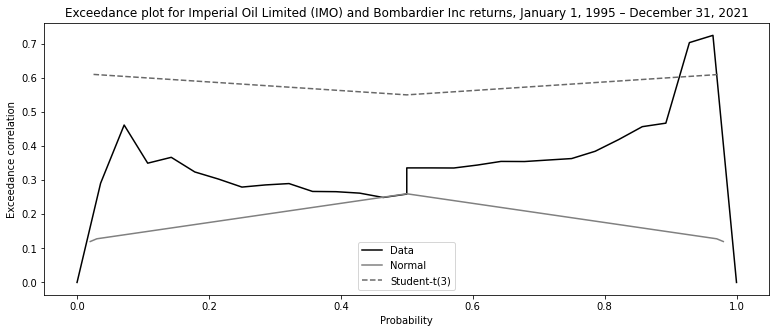

In [ ]:
fig = plt.figure(figsize=(13, 5))

plt.plot(probs, ib_corrs, color='black', label='Data')
plt.plot([0.02, 0.03, 0.5, 0.97, 0.98],
         [0.12, 0.128, 0.26, 0.128, 0.12], color='gray', label='Normal')
plt.plot([0.025, 0.5, 0.975], [0.61, 0.55, 0.61], linestyle='--', color='dimgray', label='Student-t(3)')

plt.xlabel('Probability')
plt.ylabel('Exceedance correlation')
plt.title('Exceedance plot for Imperial Oil Limited (IMO) and Bombardier Inc returns, January 1, 1995 – December 31, 2021')
plt.legend()
plt.show()

На приведенном выше графике показаны эмпирические корреляции превышения для ежедневных доходностей Imperial Oil Limited (IMO) и Bombardier Inc (BBD), входящих в S&P/TSX Composite Index, за 27 лет, наложенные на корреляции превышения для двумерного нормального распределения и двумерного распределения Стьюдента-t(3) с тем же коэффициентом корреляции.

Если говорить о нормальном распределении и распределении Стьюента с 3 степенями свободы, графики нелинейные по p, но симметричные.

Корреляции превышения уменьшаются для нормального распределения, когда мы приближаемся к крайним квантилям, в то время как они увеличиваются для Стьюдента-t(3).

В случае с активами IMO и BBD, корреляции превышения демонстрируют существенную асимметрию.

Доходности акций совсем не коррелируют в самых крайних положениях, по мере перемещения в центр распределения они резко становятся сильно коррелированными, после чего их корреляции постепенно уменьшаются.

## **Копулы**

Корреляционный анализ, который мы провели выше, помогает определить характер нелинейной зависимости (НЛЗ).

Однако есть более формальные методы моделирования НЛЗ, один из которых заключается в использовании копул.

Копулы предоставляют средства для создания многомерного распределения с рядом типов зависимости. Рассмотрим технологию использования копул ниже.

Совместное распределение нескольких случайных величин состоит из информации о каждой переменной в отдельности, а также информации о том, как различные случайные величины связаны друг с другом.

Предположим, что X и Y — две случайные величины, представляющие доходности двух разных акций,
$$ X \sim f $$
$$ Y \sim g $$

Вместе совместное распределение и маргинальные распределения представлены совместной плотностью:
$$ (X,Y) \sim h $$

Идея копулного подхода заключается в том, что мы отдельно фокусируемся на маргинальных распределениях (F, G) и функции, которая объединяет их в совместное распределение, H.

Эта функция и есть копула. Другими словами, копула извлекает информацию о структуре зависимости из совместного распределения.

Первым шагом в применении копул является преобразование X и Y в случайные величины, равномерно распределенные между нулем и единицей, что удаляет индивидуальную информацию из двумерной плотности h.

Получим равномерные величины из X и Y следующим образом (согласно теореме 1.1. Фишера Р. Э. (1925), Statistical Methods for Research Workers, Oliver & Boyd, London States):

$$ U= F(X) $$
$$ V =G(Y) $$

Далее мы приступим к моделированию структуры зависимости между полученными равномерными случайными величинами с помощью копулы.

Копула — это распределение вероятностей на единичном кубе, для которого каждое маргинальное распределение равномерно на интервале $[0; 1]$.

Копула содержит всю информацию о зависимости в исходной двумерной плотности h, но не содержит никакой индивидуальной информации.

Согласно Sklar, A. (1959), ‘‘Fonctions de reґpartition a` n dimensions et leurs marges,’’ Publ. Inst. Statis. Univ. Paris, 8, 229–231., при всех вышеперечисленных условиях существует единственная копула C такая, что:
$$ H(X, Y)= C(F(X),G(Y)) $$

Можно также разложить совместную плотность, используя плотности, на:
$$ H(X, Y)= f(X)g(Y)c(F(X),G(Y)) $$

Итак, мы отделяем распределения отдельных активов от распределения, которое связывает их вместе, и копула предоставляет информацию о том, как активы ведут себя совместно.

Таким образом, мы можем построить совместное распределение из любых двух маргинальных распределений и любой копулы и извлечь подразумеваемую копулу и маргинальные распределения из любого совместного распределения.

Попробуем применить копулы к тем же данным акций IMO и BBD.

Для начала взглянем на кросс-график доходностей акций вместе с их квантилями 0.05% и 99.95%.

In [ ]:
# скачаем ненормализованные данные еще раз
imo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/IMO.csv')
bbd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/BBD.B.csv')

# приведем их к нужному виду при помощи готовой функции
imo = asmodify(imo, 'IMO')
bbd = asmodify(bbd, 'BBD')

imo.IMO *= 100
bbd.BBD *=100

# объединим в один датафрейм
data = pd.merge(imo, bbd, on=['Date'], how='inner')

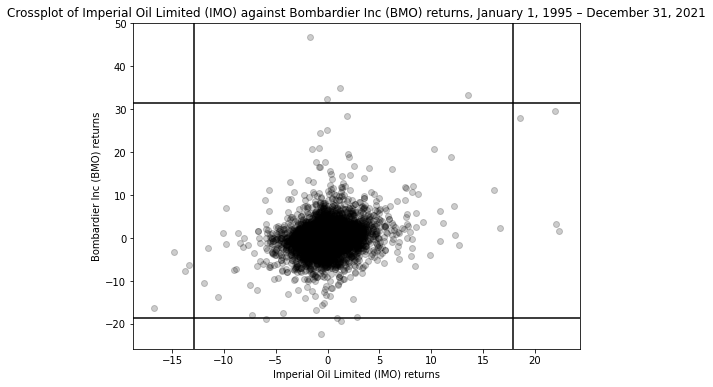

In [ ]:
fig = plt.figure(figsize=(8, 6))

# построим scatter plot для доходностей IMO и BBD
plt.scatter(x=data.IMO, y=data.BBD, alpha=0.2, color='black')

# также отметить на графике квантили распределений доходностей обоих активов
plt.axvline(data.IMO.quantile(0.0005), color='black')
plt.axvline(data.IMO.quantile(0.9995), color='black')
plt.axhline(data.BBD.quantile(0.0005), color='black')
plt.axhline(data.BBD.quantile(0.9995), color='black')
plt.xlabel('Imperial Oil Limited (IMO) returns')
plt.ylabel('Bombardier Inc (BMO) returns')
plt.title('Crossplot of Imperial Oil Limited (IMO) against Bombardier Inc (BMO) returns, January 1, 1995 – December 31, 2021')

plt.show()

Подавляющее большинство точек данных, кажется, сосредоточены вокруг нуля, но есть несколько выбросов для обеих акций, которые лежат за пределами квантилей их выборок. Нормально распределенные данные не имели бы таких общих экстремумов.

Посмотрим теперь на распределения доходностей обеих акций по отдельности и попробуем оценить на глаз, какие это могут быть распределения:

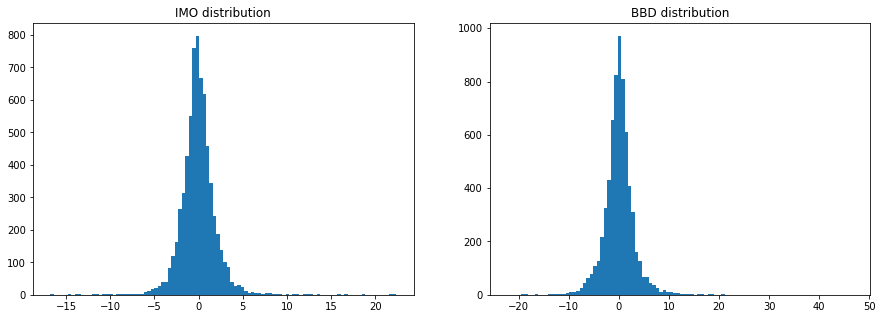

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(data.IMO, bins=100)
ax1.set_title('IMO distribution')
ax2.hist(data.BBD, bins=100)
ax2.set_title('BBD distribution')

plt.show()

Далее воспользуемся встроенной питоновской функцией Fitter(), которая по подаваемому ей на вход списку названий распределений определяет, насколько вероятно, что данные подчиняются каждому из перечисленных распределений.

,sumsquare_error,aic,bic,kl_div
burr,0.006795,1987.833430,-92478.335817,inf
cauchy,0.016301,1076.209964,-86630.903365,inf
lognorm,0.033969,3507.459532,-81700.612231,inf
beta,0.035411,3677.970132,-81413.293811,inf
norm,0.035762,3718.092805,-81364.728503,inf


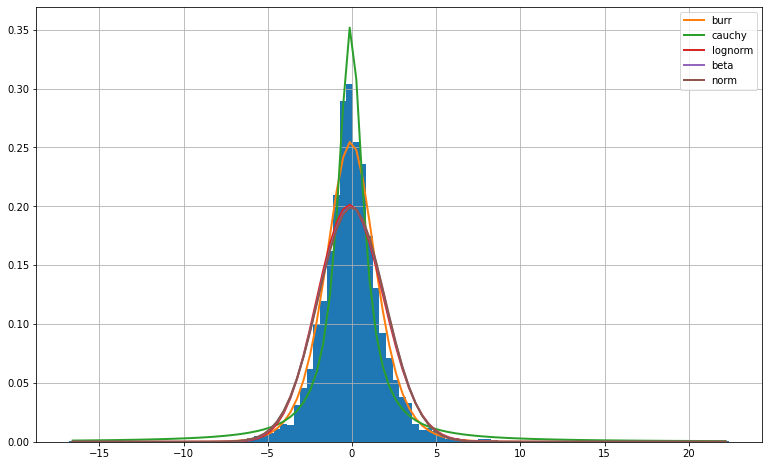

In [ ]:
from fitter import Fitter, get_common_distributions, get_distributions

# зададим функцию, подав ей на вход ряд доходностей IMO и список названий распределений
f = Fitter(data.IMO,
           distributions=['lognorm',
                          'beta',
                          'burr',
                          'norm',
                          'cauchy'])
f.fit()

fig = plt.figure(figsize=(13, 8))
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error')

{'burr': {'c': 37.16212848306275,
  'd': 0.878834202573739,
  'loc': -35.018063931325656,
  'scale': 35.12657387945953}}

Итак, мы видим, что данные по ежедневным доходностям акции IMO, вероятнее всего, подчиняются распределению Заусенцев с параметрами $x=35.12657387945953$, $c=37.16212848306275$, $k=0.878834202573739$, $\lambda=-35.018063931325656$.

,sumsquare_error,aic,bic,kl_div
cauchy,0.004642,1242.327661,-95049.847611,inf
lognorm,0.020005,4149.155550,-85249.554942,inf
beta,0.020660,4240.798584,-85024.803165,inf
norm,0.021090,5531.164559,-84904.478900,inf
burr,0.050439,2868.527270,-79042.085714,inf


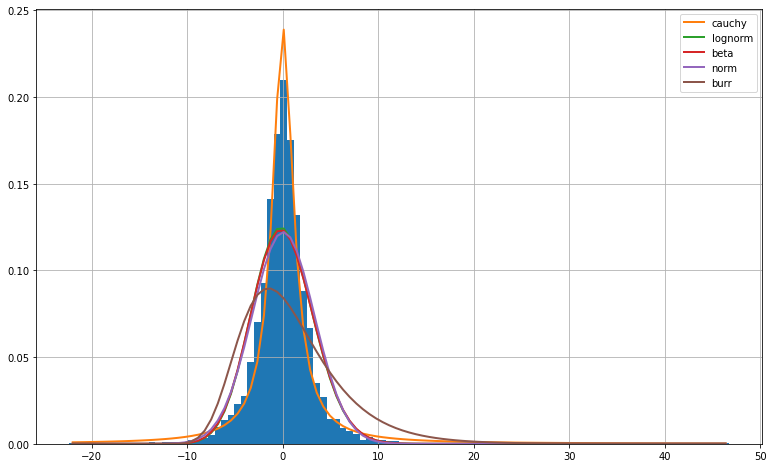

In [ ]:
# сделаем то же самое для ряда доходностей BBD
f = Fitter(data.BBD,
           distributions=['lognorm',
                          'beta',
                          'burr',
                          'norm',
                          'cauchy'])
f.fit()

fig = plt.figure(figsize=(13, 8))
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error')

{'cauchy': {'loc': 0.017072134826404222, 'scale': 1.3268151095776355}}

Ежедневные доходности акции BBD, в свою очередь, вероятнее всего подчиняются распределению Коши с параметрами $x_0=0.017072134826404222$ и $\gamma=1.3268151095776355$.

Итак, теперь взглянем на маргинальные и совместное распределения вместе:

<Figure size 576x432 with 0 Axes>

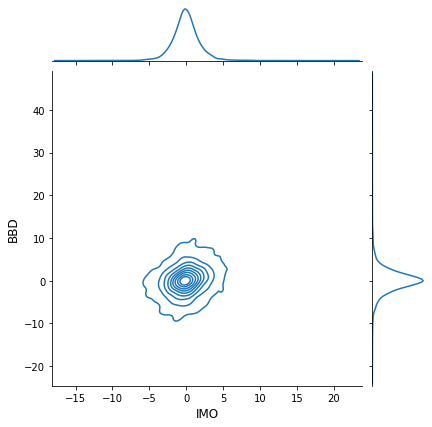

In [ ]:
fig = plt.figure(figsize=(8, 6))

h = sns.jointplot(data.IMO, data.BBD, kind='kde', stat_func=None)
h.set_axis_labels('IMO', 'BBD', fontsize=12)

plt.show()

Мы знаем, или, хотя бы, примерно догадываемся, по каким законам распределены доходности наших акций, а значит, можем преобразовать их в равномерно распределенные случайные величины.

<Figure size 576x432 with 0 Axes>

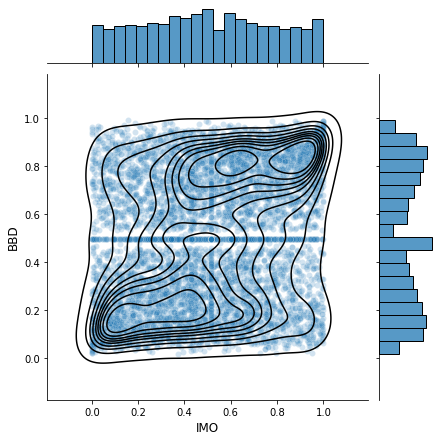

In [ ]:
fig = plt.figure(figsize=(8, 6))

burr = stats.burr(c=37.16212848306275,
                  d=0.878834202573739,
                  loc=-35.018063931325656,
                  scale=35.12657387945953)

cauchy = stats.cauchy(loc=0.017072134826404222,
                      scale=1.3268151095776355)

imo_unif = burr.cdf(data.IMO)
bbd_unif = cauchy.cdf(data.BBD)

h = sns.jointplot(imo_unif, bbd_unif, alpha=0.2)
h.plot_joint(sns.kdeplot, color='black') #, zorder=0, levels=5)
h.set_axis_labels('IMO', 'BBD', fontsize=12)

plt.show()

Совместный график, полученный выше, и есть копула.

Теперь преобразуем маргинальные распределения обратно, чтобы увидеть, что такое преобразование действительно обратимо и сохраняет в себе информацию о структуре связи между маргинальными распределениями, не меняя их:

<Figure size 576x432 with 0 Axes>

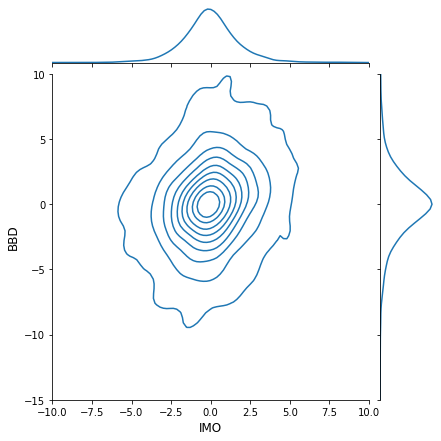

In [ ]:
fig = plt.figure(figsize=(8, 6))

imo_trans = burr.ppf(imo_unif)
bbd_trans = cauchy.ppf(bbd_unif)

h = sns.jointplot(imo_trans, bbd_trans, kind='kde', xlim=(-10, 10), ylim=(-15, 10), stat_func=None)
h.set_axis_labels('IMO', 'BBD', fontsize=12)

plt.show()

Для большей наглядности сравним полученное распределение с совместным распределением без корреляций, т.е. совместным распределений двух случайных величин, сгенерированных независимо друг от друга из тех же распределений:

<Figure size 576x432 with 0 Axes>

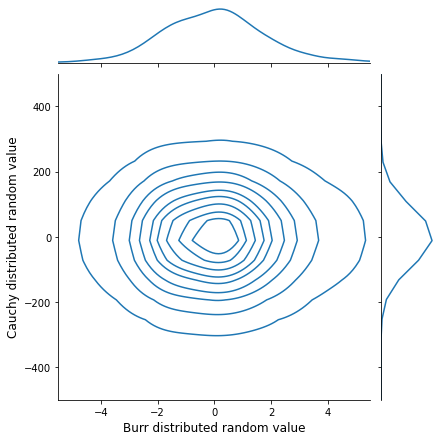

In [ ]:
fig = plt.figure(figsize=(8, 6))

imo_trans = burr.rvs(1000)
bbd_trans = cauchy.rvs(1000)

h = sns.jointplot(imo_trans, bbd_trans, kind='kde', xlim=(-5.5, 5.5), ylim=(-500, 500), stat_func=None)
h.set_axis_labels('Burr distributed random value', 'Cauchy distributed random value', fontsize=12)

plt.show()

Таким образом, можно подвести итог, что копулы действительно работают.

Также мы можем не делать никаких предположений о распределении данных, т.е. не использовать fitter.Fitter(), а попробовать применить к данным некоторые распространенные копулы, реализованные, например, в библиотеке copulae, и посмотреть на результат.

Начнем с самой распространенной копулы, Гауссовской:

In [ ]:
from copulae import GaussianCopula

# зададим размерность измерения, в нашем случае, укажем количество акций
ndim = 2

# инициализируем копулу
g_cop = GaussianCopula(dim=ndim)

# обучим копулу на данных (или подгоним ее под них)
g_cop.fit(data[['IMO', 'BBD']])

               IMO          BBD
count  6703.000000  6703.000000
mean      0.500000     0.500000
std       0.288650     0.288588
min       0.000149     0.000149
25%       0.250075     0.250075
50%       0.500000     0.497837
75%       0.749925     0.749925
max       0.999851     0.999851


Взглянем на оцениваемый параметр, который является коэффициентом корреляции для Гауссовской копулы:

In [ ]:
g_cop.summary()

1.000000,0.233969
0.233969,1.000000


Попробуем применить обученную копулу.

<Figure size 576x432 with 0 Axes>

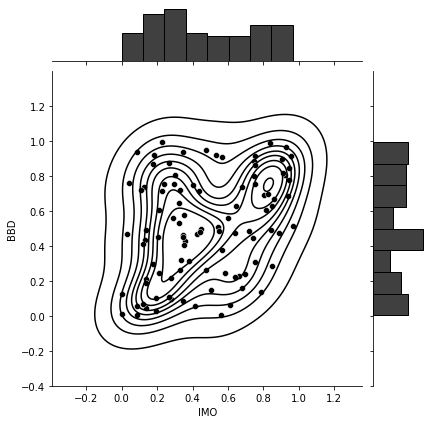

In [ ]:
# сгенерируем с помощью полученной копулы 2 равномерно распределенные случайные величины,
# которые должны иметь ту же зависимость двумерной плотности, что и изначальные
rv = g_cop.random(100)

fig = plt.figure(figsize=(8, 6))

# посмотрим на их совместное распределение (по сути, визуализируем копулу)
h = sns.jointplot(rv.IMO, rv.BBD, color='black')

h.plot_joint(sns.kdeplot, color='black') #, zorder=0, levels=6)
# h.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

# h.set_axis_labels('IMO', 'BBD', fontsize=12)


plt.show()

In [ ]:
# на всякий случай, проверим, что полученные при помощи копулы случайные величины распределены равномерно на отрезке от 0 до 1
rv.describe()

,IMO,BBD
count,100.000000,100.000000
mean,0.470834,0.511056
std,0.280857,0.290193
min,0.000135,0.003706
25%,0.229241,0.255536
50%,0.430500,0.491758
75%,0.743521,0.752450
max,0.964814,0.993665


И снова видим, что копула действительно работает.

Повторим все то же самое для копулы Стьюдента.

In [ ]:
from copulae import StudentCopula

degrees_of_freedom = 3  # some random number, unnecessary to specify df but done for demonstration purposes
t_cop = StudentCopula(dim=ndim, df=degrees_of_freedom)
t_cop.fit(data[['IMO', 'BBD']])

               IMO          BBD
count  6703.000000  6703.000000
mean      0.500000     0.500000
std       0.288650     0.288588
min       0.000149     0.000149
25%       0.250075     0.250075
50%       0.500000     0.497837
75%       0.749925     0.749925
max       0.999851     0.999851


И вновь посмотрим на оцениваемые параметры. На этот раз, это коэффициент корреляции, а также степень свободы t:

In [ ]:
t_cop.summary()

1.000000,0.234875
0.234875,1.000000


<Figure size 576x432 with 0 Axes>

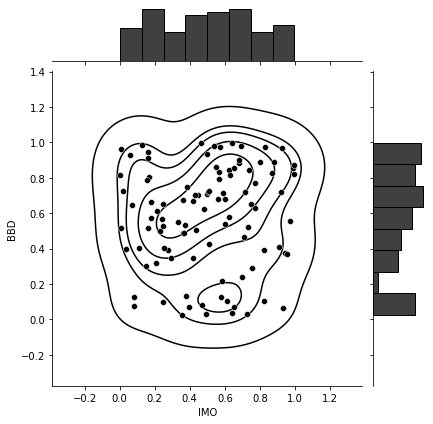

In [ ]:
t_rv = t_cop.random(100)

fig = plt.figure(figsize=(8, 6))

h = sns.jointplot(t_rv.IMO, t_rv.BBD, color='black')

h.plot_joint(sns.kdeplot, color='black', zorder=0, levels=6)
# h.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

# h.set_axis_labels('IMO', 'BBD', fontsize=12)


plt.show()

Теперь используем для данных копулу Клейтона.

In [ ]:
from copulae import ClaytonCopula

cl_cop = ClaytonCopula(dim=ndim)
cl_cop.fit(data[['IMO', 'BBD']])

               IMO          BBD
count  6703.000000  6703.000000
mean      0.500000     0.500000
std       0.288650     0.288588
min       0.000149     0.000149
25%       0.250075     0.250075
50%       0.500000     0.497837
75%       0.749925     0.749925
max       0.999851     0.999851


In [ ]:
cl_cop.summary()

Clayton Copula Summary
================================================================================
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 0.2538746382777034

<Figure size 576x432 with 0 Axes>

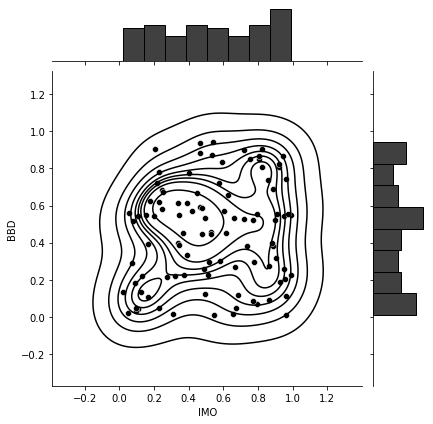

In [ ]:
cl_rv = cl_cop.random(100)

fig = plt.figure(figsize=(8, 6))

h = sns.jointplot(cl_rv.IMO, cl_rv.BBD, color='black')

h.plot_joint(sns.kdeplot, color='black') #, zorder=0, levels=6)
# h.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

# h.set_axis_labels('IMO', 'BBD', fontsize=12)


plt.show()

Таким образом, мы попробовали применить к нашим данным некоторые типы копул, но неясно, дает ли копула, которая имеет хорошее соответствие, хорошее соответствие для распределения данных.

Итак, мы увидели, что доходность наших финансовых активов не представляют собой независимые одинаково распределенные случайные величины (independent and identically distributed random variables, IID), как предполагают многие приложения в финансах.

Хорошо известно, что финансовые доходы подчиняются сложной и постоянно меняющейся функции распределения вероятностей, и мы можем надеяться статистически смоделировать лишь очень небольшую часть распределения доходов в любой момент времени.

Мы попытались эмпирически выявить такие стилизованные факты о рядах доходностей, как кластеры волатильности, тяжелые хвосты и нелинейная зависимость, с использованием ряда статистических методов.

Теперь мы можем попробовать применить к ним статистические методы прогнозирования.

## **Прогнозирование временных рядов**

Ниже мы рассмотрим некоторые самые распространенные модели, используемые для прогнозирования временных рядов, и применим их к ряду дневных доходностей S&P/TSX Composite Index.

## **Проверка стационарности**

Чаще всего ряд доходностей (ряд первых разностей) стационарен, вследствие чего нет необходимости обосновывать применимость тех или иных методов. Посмотрим, является ли ряд дневных доходностей S&P/TSX Composite Index стационарным, для этого применим к нему расширенный тест Дикки-Фуллера (аugmented Dickey-Fuller Testing), который является наиболее распространенным тестом на единичный корень (unit root testing).

Нулевая гипотеза, в этом случае, состоит в том, что ряд содержит единичный корень, а альтернативная - в том, что ряд является стационарным.

In [ ]:
from arch.unitroot import ADF

adf = ADF(daily_return['Daily return'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -24.383
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Так как уровень значимости значительно меньше 0.05 и даже 0.01, у нас есть основание отвергнуть нулевую гипотезу, а значит, мы принимаем альтернативную гипотезу, которая гласит, что временной ряд стационарен.

Теперь, еще раз убедившись в стационарности наших данных, перейдем к построению моделей.

## **ARMA модель**

Модель авторегрессии — скользящего среднего (autoregressive moving-average model, ARMA) - это совмещение более простых моделей AR (авторегрессионной модели, или autoregressive model) и MA (модели скользящего среднего, или moving average model).

Модель AR(L2) пытается объяснить эффекты импульса, то есть взаимосвязи с данными за прошлые периоды, часто наблюдаемые на торговых рынках (эффекты участников рынка):

$$ X_t = \mu + \sum_{i=1}^{L_2} \beta_i X_{t-i} + \epsilon_t $$

Модель MA(L1) пытается отразить шоковые эффекты, наблюдаемые в терминах белого шума. Эти шоковые эффекты можно рассматривать как неожиданные события, влияющие на процесс наблюдения, такие как внезапные заработки, войны, кризисы и прочее:

$$ X_t = \mu + \epsilon_t + \sum_{i=1}^{L_1} \alpha_i \epsilon_{t-i} $$

В обеих формулах выше случайные шоки, или остатки, $\epsilon_t$ являются независимыми одинаково распределёнными случайными величинами, причем $\epsilon_t \sim N(0, \sigma^2)$.

Модель ARMA(L2, L1) пытается охватить оба этих аспекта при моделировании финансовых временных рядов. Но она не принимает во внимание кластеризацию волатильности, ключевой эмпирический феномен многих финансовых временных рядов:

$$ X_t = \mu + \sum_{i=1}^{L_2} \beta_i X_{t-i} + \epsilon_t + \sum_{j=1}^{L_1} \alpha_j \epsilon_{t-j} $$


In [ ]:
# скачаем более поздние данные и реверсируем их, т.е. расположим строки в порядке от более новых к более старым
data_last = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/проект по анализу и прогнозированию рыночных рисков/новые данные ^GSPTSE.csv')
data_last = data_last.iloc[::-1].reset_index(drop=True)

# нас интересуют столбцы с датой и значением цены закрытия, сохраним их в переменную daily_close_last
daily_close_last = data_last[['Date', 'Adj Close']]

# вычислим простые доходности с помощью фцнкции .pct_change()
daily_return_last = pd.concat([daily_close_last['Date'], daily_close_last['Adj Close'].pct_change()], axis=1)
daily_return_last.fillna(0, inplace=True)
daily_return_last.rename(columns={'Adj Close':'Daily return'}, inplace=True)

# столбец Date имеет тип object, поменяем его на datetime
daily_return_last['Date'] = pd.to_datetime(daily_return_last['Date'], dayfirst=True)

In [ ]:
# имплементируем и обучим модель на прошлых данных
arma = smt.ARMA(daily_return['Daily return'].values, order=(2, 2))
arma = arma.fit(method='mle', trend='nc')

# получим предсказания для следующих 10 дней
predictions = arma.predict(start=0, end=9)

In [ ]:
print(arma.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                10924
Model:                     ARMA(2, 2)   Log Likelihood               35031.834
Method:                           mle   S.D. of innovations              0.010
Date:                Sun, 13 Mar 2022   AIC                         -70053.668
Time:                        10:13:50   BIC                         -70017.174
Sample:                             0   HQIC                        -70041.369
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.1030      0.100      1.030      0.303      -0.093       0.299
ar.L2.y        0.7597      0.074     10.206      0.000       0.614       0.906
ma.L1.y       -0.0684      0.101     -0.677      0.4

Мы задали модель, после чего обучили ее, используя метод максимального правдоподобия (задали соответствующий параметр при обучении). В таблице выше приведены полученные по результатам обучения модели ARMA(2, 2) коэффициенты, все они по модулю не превышают 1.

Сравним полученные прогнозы ежедневной доходности индекса для первых дней 2022 года с реальными значениями.

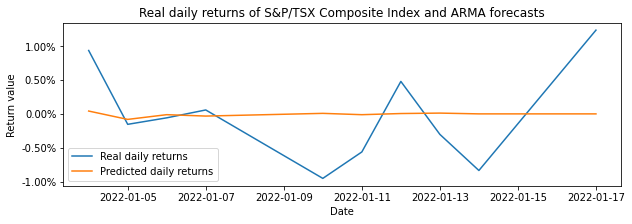

In [ ]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(111)
plot1 = ax.plot(daily_return_last['Date'].tail(10), daily_return_last['Daily return'].tail(10) * 100, label='Real daily returns')
plot2 = ax.plot(daily_return_last['Date'].tail(10), predictions * 100, label='Predicted daily returns')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Date')
plt.ylabel('Return value')
plt.title('Real daily returns of S&P/TSX Composite Index and ARMA forecasts')
plt.legend()
plt.show()

На графике четко видно, что предсказательная способность обученной модели оставляет желать лучшего, а точнее, она очень и очень плохая.

Попробуем взглянуть на автокорреляционные функции (и их доверительные интервалы) и графики квантиль-квантиль для реальных и спрогнозированных данных, соответственно.

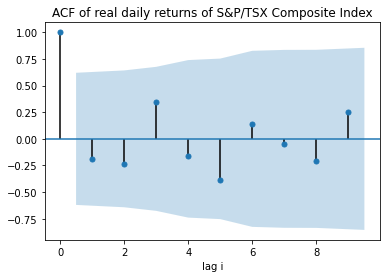

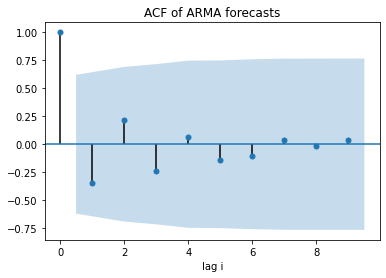

In [ ]:
smt.graphics.plot_acf(daily_return_last['Daily return'].tail(10))
plt.xlabel('lag i')
plt.title('ACF of real daily returns of S&P/TSX Composite Index')

smt.graphics.plot_acf(predictions)
plt.xlabel('lag i')
plt.title('ACF of ARMA forecasts')

plt.show()

# arma.wald_test()

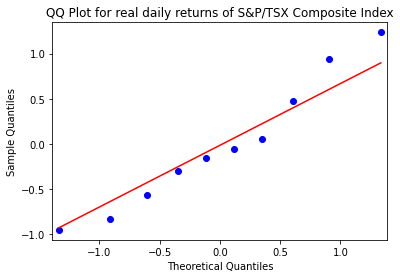

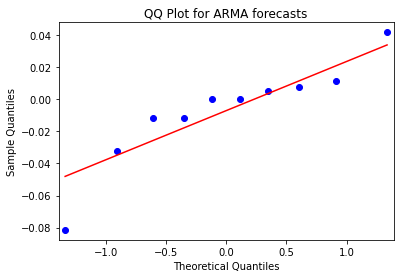

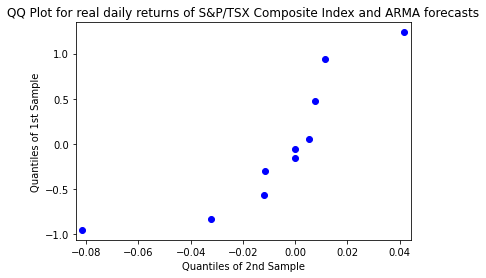

In [ ]:
sm.qqplot(daily_return_last['Daily return'].tail(10) * 100, line='s')
plt.title('QQ Plot for real daily returns of S&P/TSX Composite Index')

sm.qqplot(predictions * 100, line='s')
plt.title('QQ Plot for ARMA forecasts')

qqplot_2samples(daily_return_last['Daily return'].tail(10) * 100, predictions * 100)
plt.title('QQ Plot for real daily returns of S&P/TSX Composite Index and ARMA forecasts')

plt.show()

Полученная модель уловила некоторые (совсем чуть-чуть) взаимосвязи данных во времени, что видно по автокорреляционной функции, однако предсказанные ею значения для первых 10 дней 2022 года не просто значительно отличаются от реальных, но и имеют другое распределение, что видно, в том числе, из приведенных выше QQ Plots.

Попробуем подобрать значения L1 и L2, а не задавать их самостоятельно, чтобы улучшить результаты модели. Для этого будем перебирать значения для L1 и L2 от 1 до 5 и оценивать получаемые результаты модели, обученной на каждой паре значений, по критерию AIC (Akaike Information Criterion), который автоматически подсчитывается для обученной модели.

In [ ]:
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(1, 6)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(daily_return['Daily return'].values,
                      order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: %6.2f | order: %s'%(best_aic, best_order))

aic: -70064.97 | order: (4, 4)


Мы обучили модели со всеми парами значений для L1 и L2 и получили лучшее соотношение: L1 = 4 и L2 = 4.

Посмотрим на графики, аналогичные приведенным выше, для лучшей модели.

In [ ]:
print(best_mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                10924
Model:                     ARMA(4, 4)   Log Likelihood               35041.485
Method:                           mle   S.D. of innovations              0.010
Date:                Sun, 13 Mar 2022   AIC                         -70064.971
Time:                        11:18:23   BIC                         -69999.282
Sample:                             0   HQIC                        -70042.833
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y       -0.2008      0.324     -0.619      0.536      -0.837       0.435
ar.L2.y       -0.4680      0.184     -2.540      0.011      -0.829      -0.107
ar.L3.y       -0.3499      0.258     -1.358      0.1

In [ ]:
best_predictions = best_mdl.predict(start=0, end=9)

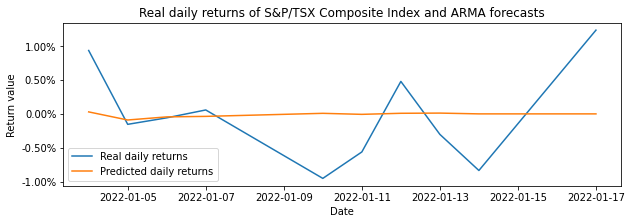

In [ ]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(111)
plot1 = ax.plot(daily_return_last['Date'].tail(10), daily_return_last['Daily return'].tail(10) * 100, label='Real daily returns')
plot2 = ax.plot(daily_return_last['Date'].tail(10), best_predictions * 100, label='Predicted daily returns')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Date')
plt.ylabel('Return value')
plt.title('Real daily returns of S&P/TSX Composite Index and ARMA forecasts')
plt.legend()
plt.show()

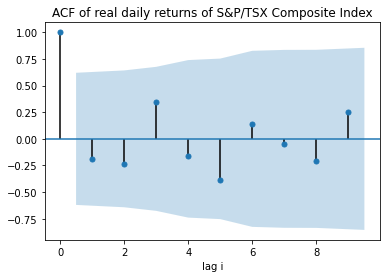

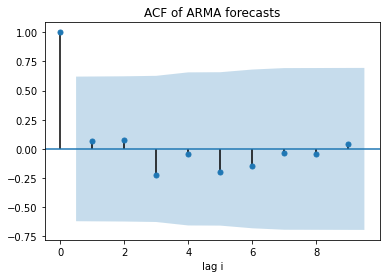

In [ ]:
smt.graphics.plot_acf(daily_return_last['Daily return'].tail(10))
plt.xlabel('lag i')
plt.title('ACF of real daily returns of S&P/TSX Composite Index')

smt.graphics.plot_acf(best_predictions)
plt.xlabel('lag i')
plt.title('ACF of ARMA forecasts')

plt.show()

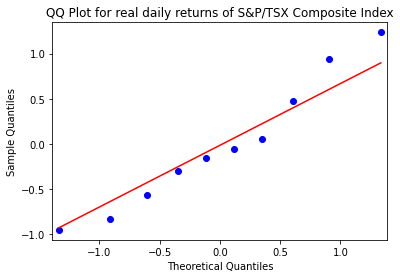

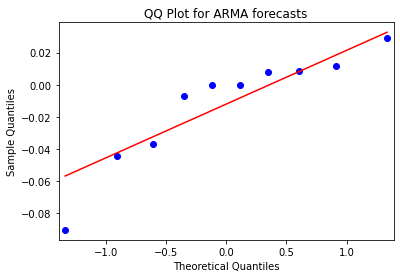

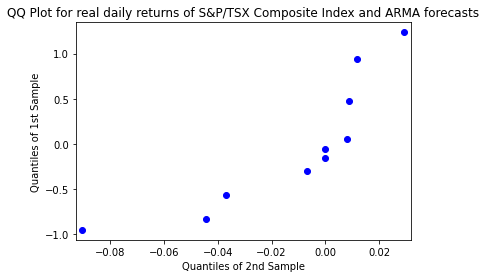

In [ ]:
sm.qqplot(daily_return_last['Daily return'].tail(10) * 100, line='s')
plt.title('QQ Plot for real daily returns of S&P/TSX Composite Index')

sm.qqplot(best_predictions * 100, line='s')
plt.title('QQ Plot for ARMA forecasts')

qqplot_2samples(daily_return_last['Daily return'].tail(10) * 100, best_predictions * 100)
plt.title('QQ Plot for real daily returns of S&P/TSX Composite Index and ARMA forecasts')

plt.show()

Качество предсказаний по-прежнему страдает, хотя и можно заметить чуть больше совпадений корреляционных функций для реальных и предсказанных значений.

Применим к остаткам лучшей модели уже опробованный нами ранее тест Льюнга-Бокса, чтобы наверняка определить, было ли достигнуто хорошее соответствие для L1 = 4 и L2 = 4. Если p-значение теста будет больше требуемой значимости, можно сделать вывод, что остатки независимы и являются белым шумом.

In [ ]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[10])[1][0]

0.00014850656311690398

Как можно было ожидать, p-значение значительно меньше 0.05, что говорит нам о том, что остатки модели ARMA(4, 4), обученной на исторических доходностях S&P/TSX Composite Index, не являются дискретным белым шумом, а значит, в остатках присутствует дополнительная автокорреляция, которая не объясняется подобранной моделью ARMA(4, 4). Это видно и из графика остатков, приведенного выше, мы видим области явной условной волатильности (гетероскедастичности), которые модель не уловила (возможно, по этому все же не стоит судить, так как мы решили предсказать данные лишь на 10 дней вперед).

Попробуем обучить другую модель и посмотреть на ее результаты.

## **ARCH модель**

Модель авторегрессионной условной гетероскедастичности (AutoRegressive Conditional Heteroscedasticity, ARCH) использует в качестве шоков волатильности наблюдаемые значения доходности, или остатки, и выглядит следующим образом:

$$ Y_t = \sigma_t Z_t $$
$$ \sigma_t^2 = \omega \ + \sum_{i=1}^{L_1} \alpha_i Y_{t-i}^2, $$

где $Z_t$ - это белый шум, а $L_1$ - количество лагов.

Важно отметить, что как условное, так и безусловное математическое ожидание такого процесса равно нулю.

In [ ]:
# децентрируем временной ряд

daily_return['Daily return'] -= daily_return['Daily return'].mean()
daily_return_last['Daily return'] -= daily_return_last['Daily return'].mean()

In [ ]:
def best_model(func='ARCH', p=5, q=1, dist='normal'):
    best_llh = - np.inf
    best_order = None
    best_arch = None

    pp = range(1, p + 1)
    qq = range(1, q + 1)
    for p in pp:
        for q in qq:
            try:
                arch = arch_model( daily_return[daily_return['Date'].dt.year > 2017]['Daily return'] * 100,
                                  mean='Zero', vol=func, p=p, q=q, dist=dist)
                arch = arch.fit()
                arch_llh = arch.loglikelihood
                if arch_llh > best_llh:
                    best_llh = arch_llh
                    best_order = (p, q)
                    best_arch = arch
            except: continue


    print('log-likelihood: %6.2f | (p, q): %s'%(best_llh, best_order))
    return best_arch

In [ ]:
# from arch import arch_model

# arch = arch_model(daily_return['Daily return'], mean='Zero', vol='ARCH', p=5)
# arch = arch.fit()

arch = best_model(func='ARCH', p=5)

Iteration:      1,   Func. Count:      4,   Neg. LLF: 1155.3513914668492
Iteration:      2,   Func. Count:      9,   Neg. LLF: 1154.9983914211564
Iteration:      3,   Func. Count:     15,   Neg. LLF: 1154.9648549936453
Iteration:      4,   Func. Count:     20,   Neg. LLF: 1154.5509292017655
Iteration:      5,   Func. Count:     24,   Neg. LLF: 1154.4564686396036
Iteration:      6,   Func. Count:     28,   Neg. LLF: 1154.4557101331022
Iteration:      7,   Func. Count:     32,   Neg. LLF: 1154.4557087228918
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1154.4557087228784
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1055.2935083587297
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1054.069693860553
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1053.523792504352
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1053.1562

In [ ]:
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:           Daily return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1020.24
Distribution:                  Normal   AIC:                           2052.48
Method:            Maximum Likelihood   BIC:                           2081.95
                                        No. Observations:                 1005
Date:                Mon, Mar 14 2022   Df Residuals:                     1005
Time:                        10:59:22   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1113  1.822e-02      6.110  9.992e-10 

Проверим, что выполняются следующие важные ограничения, накладываемые на параметры ARCH(L1) модели:
1.  $ \omega, \ \alpha_i > 0, \ ∀ i = 1, ..., L_1$, что обеспечивает положительность прогнозов волатильности
2. сумма всех коэффициентов $ \sum_{i=1}^{L_1} \alpha_i \ < 1 $, что обеспечивает стационарность ковариации, чтобы определить безусловную волатильность.

Также мы можем вспомнить о правиле, которое гласит, чем выше альфы, тем толще хвосты. Все соответствующие коэффициенты нашей обученной модели лежат в интервале от 0.02 до 0.3, из чего мы можем сделать предположение, что распределение данных, которые будет прогнозировать полученная модель, будет иметь не сильно толстые хвосты.

In [ ]:
arch_predictions = arch.forecast(horizon=daily_return_last.shape[0])

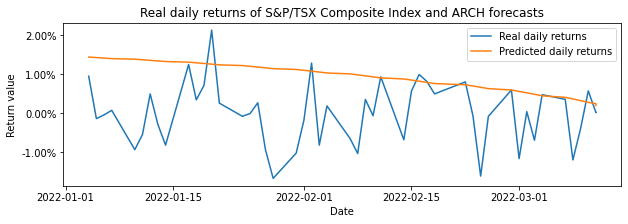

In [ ]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(111)
plot1 = ax.plot(daily_return_last['Date'], daily_return_last['Daily return'] * 100, label='Real daily returns')
plot2 = ax.plot(daily_return_last['Date'], arch_predictions.variance.values[-1, :], label='Predicted daily returns')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Date')
plt.ylabel('Return value')
plt.title('Real daily returns of S&P/TSX Composite Index and ARCH forecasts')
plt.legend()
plt.show()

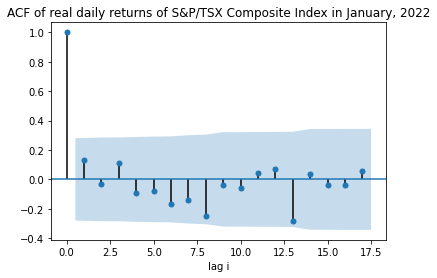

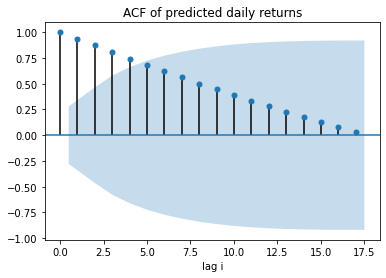

In [ ]:
# plt.plot(arch_predictions.variance.values[-1, :])

smt.graphics.plot_acf(daily_return_last['Daily return'])
plt.xlabel('lag i')
plt.title('ACF of real daily returns of S&P/TSX Composite Index in January, 2022')

smt.graphics.plot_acf(arch_predictions.variance.values[-1, :])
plt.xlabel('lag i')
plt.title('ACF of predicted daily returns')

plt.show()

## **GARCH модель**

ARCH-модель предполагает зависимость условной дисперсии только от квадратов прошлых значений временного ряда, однако, можно обобщить данную модель, предположив, что условная дисперсия зависит также от квадратов прошлых значений самой условной дисперсии, таким образом, мы сможем учесть влияние исторической доходности. Такая модель называется обобщённым ARCH (Generalized ARCH — GARCH(L1, L2)) и описывается следующим образом:

$$ Y_t = \sigma_t Z_t $$
$$ \sigma_t^2 = \omega \ + \sum_{i=1}^{L_1} \alpha_i Y_{t-i}^2 + \sum_{j=1}^{L_2} \beta_j \sigma_{t-j}^2. $$

In [ ]:
# garch = arch_model(daily_return[daily_return['Date'].dt.year > 2017]['Daily return'], mean='Zero', vol='GARCH', p=5, q=5)
# garch = garch.fit()

garch = best_model(func='GARCH', p=5, q=5)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1033.4288480583277
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1027.2633929234014
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1021.4650670534262
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1020.6991893541415
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1020.6079634521088
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1020.4322622334646
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1020.3669793586702
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1020.3591129212216
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1020.3590264794123
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1020.3590264796935
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1048.7301543699787
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1038.27

In [ ]:
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:           Daily return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1017.54
Distribution:                  Normal   AIC:                           2055.08
Method:            Maximum Likelihood   BIC:                           2104.21
                                        No. Observations:                 1005
Date:                Mon, Mar 14 2022   Df Residuals:                     1005
Time:                        11:00:05   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0875  9.887e-02      0.885      0.376    [ -

Как и в модели ARCH(L1), на параметры модели GARCH(L1, L2) накладываются два типа ограничений, которые, как можно видеть из таблицы выше, выполняются для реализованной модели:
1. Для обеспечения положительных прогнозов волатильности: $ \omega, \ \alpha_i, \ \beta_j > 0, \ ∀ i = 1, ..., L_1 \land j = 1, ..., L_2$
2. Для обеспечения стационарности ковариации: $ \sum_{i=1}^{L_1} \alpha_i \ + \sum_{j=1}^{L_2} \beta_j \ < 1 $

In [ ]:
garch_predictions = garch.forecast(horizon=daily_return_last.shape[0])

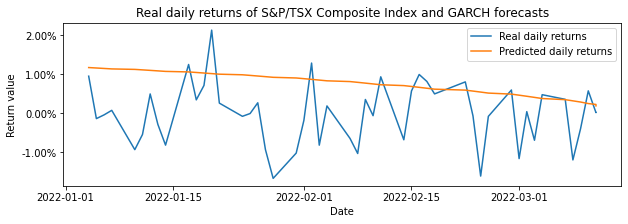

In [ ]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(111)
plot1 = ax.plot(daily_return_last['Date'], daily_return_last['Daily return'] * 100, label='Real daily returns')
plot2 = ax.plot(daily_return_last['Date'], garch_predictions.variance.values[-1, :], label='Predicted daily returns')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Date')
plt.ylabel('Return value')
plt.title('Real daily returns of S&P/TSX Composite Index and GARCH forecasts')
plt.legend()
plt.show()

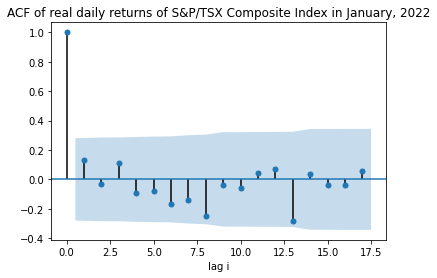

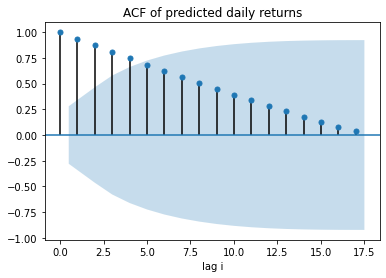

In [ ]:
smt.graphics.plot_acf(daily_return_last['Daily return'])
plt.xlabel('lag i')
plt.title('ACF of real daily returns of S&P/TSX Composite Index in January, 2022')

smt.graphics.plot_acf(garch_predictions.variance.values[-1, :])
plt.xlabel('lag i')
plt.title('ACF of predicted daily returns')

plt.show()

## **Сравнение моделей**

Мы построили некоторые модели, теперь попробуем продиагностировать их вместе. Но перед этим построим еще 2 модели типа GARCH(L1, L2), на этот раз уже будем использовать распределение Стьюдента-t.

In [ ]:
tgarch = best_model(func='GARCH', p=5, q=5, dist='t')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1018.4124606541055
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1013.1277820693826
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1008.4126510497281
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1008.1589391038985
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1007.9711312748431
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1007.9624745888368
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1007.9618613797654
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1007.9618193938561
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1007.961818177828
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1007.961818177829
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      7,   Neg. LLF: 1031.835366420489
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1022.38531

In [ ]:
skewtgarch = best_model(func='GARCH', p=5, q=5, dist='skewt')

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1018.4124596531358
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1011.3262726299719
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1006.0255093748773
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1005.352356032564
Iteration:      5,   Func. Count:     41,   Neg. LLF: 1005.2633221227915
Iteration:      6,   Func. Count:     50,   Neg. LLF: 1005.054779665455
Iteration:      7,   Func. Count:     57,   Neg. LLF: 1005.0097909643318
Iteration:      8,   Func. Count:     64,   Neg. LLF: 1004.9794383426128
Iteration:      9,   Func. Count:     71,   Neg. LLF: 1004.9770467852956
Iteration:     10,   Func. Count:     78,   Neg. LLF: 1004.9768062071169
Iteration:     11,   Func. Count:     85,   Neg. LLF: 1004.9767894955484
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1004.9767890008034
            Iterations: 11
            Function evaluations: 86
            Gradient eval

Итак, мы построили еще 2 лучшие модели путем перебора значений L1 и L2, теперь мы можем составить таблицу со всеми параметрами всех полученных моделей.

In [ ]:
# зададим таблицу
models_info = pd.DataFrame(index=['Log_likelihood',
                                  'ω',
                                  'α1', 'α2', 'α3', 'α4', 'α5', #'α6', 'α7', 'α8', 'α9', 'α10', 'α11', 'α12', 'α13', 'α14', 'α15',
                                  'β1', 'β2', 'β3', 'β4', 'β5', #'β6', 'β7', 'β8', 'β9', 'β10', 'β11', 'β12', 'β13', 'β14', 'β15',
                                  'v', 'Skew'],
                           columns=pd.MultiIndex.from_tuples(
                               zip(['ARCH(5)', 'GARCH(4, 5)', 'GARCH(4, 5)', 'GARCH(4, 5)'],
                                   ['Normal', 'Normal', 'Student-t', 'Skew Student-t']),
                                   names=['', 'Conditional distribution']))

In [ ]:
# заполним таблицу
models_info.iloc[0, 0] = arch.loglikelihood
models_info.iloc[1:7, 0] = arch.params.values # omega and alphas

models_info.iloc[0, 1] = garch.loglikelihood
models_info.iloc[1, 1] = garch.params.omega
models_info.iloc[2:6, 1] = garch.params.values[1:5] # alphas
models_info.iloc[7:12, 1] = garch.params.values[5:10] # betas

models_info.iloc[0, 2] = tgarch.loglikelihood
models_info.iloc[1, 2] = tgarch.params.omega
models_info.iloc[2:6, 2] = tgarch.params.values[1:5] # alphas
models_info.iloc[7:12, 2] = tgarch.params.values[5:10] # betas
models_info.iloc[12, 2] = tgarch.params.nu # degree of freedom

models_info.iloc[0, 3] = skewtgarch.loglikelihood
models_info.iloc[1, 3] = skewtgarch.params.omega
models_info.iloc[2:6, 3] = skewtgarch.params.values[1:5] # alphas
models_info.iloc[7:12, 3] = skewtgarch.params.values[5:10] # betas
models_info.iloc[12, 3] = skewtgarch.params.eta # degree of freedom
models_info.iloc[13, 3] = skewtgarch.params['lambda'] # skew

models_info = models_info.fillna('')

In [ ]:
# зададим нужный стиль и выведем на экран
mod_info = models_info.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
mod_info.set_properties(**{'text-align': 'center'})

Из таблицы выше можно увидеть, что сумма $ \sum_{i=1}^{L_1} \alpha_i \ + \sum_{j=1}^{L_2} \beta_j $ близка к 1 для большинства обученных моделей, а как мы знаем, при таких больших значениях коэффициентов появляются проблемы с безусловной волатильностью.

In [ ]:
from scipy.stats.distributions import chi2

def likelihood_ratio(llu, llr, df):

    # llu - unrestricted log-likelihood
    # llr - restricted log-likelihood
    # numr - number of restrictions

    LR = 2 * (llu - llr)
    # pvalue = 1 - chi2(df).cdf(LR)
    pvalue = round(chi2.sf(LR, df), 3)
    return LR, pvalue

Посмотрим на результаты тестов отношения правдоподобия (likelihood ratio tests) оценочных моделей в таблице ниже.

In [ ]:
# зададим таблицу
models_lr_test = pd.DataFrame({
    'Unrestricted model': ['ARCH(5)', 'GARCH(4, 5)', 't-GARCH(4, 5)', 'Skew-t-GARCH(4, 5)'],
    'Restricted model': ['ARCH(1)', 'GARCH(1, 1)', 'GARCH(4, 5)', 't-GARCH(4, 5)'],
    'LR statistic': [0] * 4,
    'Restrictions': [0] * 4,
    'p-value': [0] * 4
})

In [ ]:
arch1 = arch_model(daily_return[daily_return['Date'].dt.year > 2017]['Daily return'] * 100, mean='Zero', vol='ARCH', p=1)
arch1 = arch1.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 1155.3513914668492
Iteration:      2,   Func. Count:      9,   Neg. LLF: 1154.9983914211564
Iteration:      3,   Func. Count:     15,   Neg. LLF: 1154.9648549936453
Iteration:      4,   Func. Count:     20,   Neg. LLF: 1154.5509292017655
Iteration:      5,   Func. Count:     24,   Neg. LLF: 1154.4564686396036
Iteration:      6,   Func. Count:     28,   Neg. LLF: 1154.4557101331022
Iteration:      7,   Func. Count:     32,   Neg. LLF: 1154.4557087228918
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1154.4557087228784
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7


In [ ]:
garch11 = arch_model(daily_return[daily_return['Date'].dt.year > 2017]['Daily return'] * 100, mean='Zero', vol='GARCH', p=1, q=1)
garch11 = garch11.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1033.4288480583277
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1027.2633929234014
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1021.4650670534262
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1020.6991893541415
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1020.6079634521088
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1020.4322622334646
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1020.3669793586702
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1020.3591129212216
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1020.3590264794123
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1020.3590264796935
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9


In [ ]:
numr = arch.num_params - arch1.num_params
LR, pvalue = likelihood_ratio(arch.loglikelihood,
                              arch1.loglikelihood,
                              numr)

models_lr_test.iloc[0, 2:] = LR, numr, pvalue


numr = garch.num_params - garch11.num_params
LR, pvalue = likelihood_ratio(garch.loglikelihood,
                              garch11.loglikelihood,
                              numr)

models_lr_test.iloc[1, 2:] = LR, numr, pvalue


numr = tgarch.num_params - garch.num_params
LR, pvalue = likelihood_ratio(tgarch.loglikelihood,
                              garch.loglikelihood,
                              numr)

models_lr_test.iloc[2, 2:] = LR, numr, pvalue


numr = skewtgarch.num_params - tgarch.num_params
LR, pvalue = likelihood_ratio(skewtgarch.loglikelihood,
                              tgarch.loglikelihood,
                              numr)

models_lr_test.iloc[3, 2:] = LR, numr, pvalue

In [ ]:
models_lr_test

,Unrestricted model,Restricted model,LR statistic,Restrictions,p-value
0,ARCH(5),ARCH(1),268.436374,4,0.000
1,"GARCH(4, 5)","GARCH(1, 1)",5.636671,7,0.583
2,"t-GARCH(4, 5)","GARCH(4, 5)",23.560268,1,0.000
3,"Skew-t-GARCH(4, 5)","t-GARCH(4, 5)",5.637818,1,0.018


Из таблицы выше видно, что ARCH(5) значительно лучше ARCH(1), что неудивительно, поскольку мы ожидаем, что зависимость от волатильности продлится много дней.

При добавлении запаздывающей волатильности в модели GARCH(4, 5) соответствие между моделями резко улучшаться, и если сравнивать GARCH(4, 5) с GARCH(1, 1), они оказываются гораздо более схожими (на это, конечно же, также влияют сами данные, под которые подгоняются модели).

Использование Стьюдента-t в качестве условного распределения также значительно улучшает обычную версию модели GARCH, в то время как асимметричное распределение Стьюдента-t оказывается еще лучше, чем симметричное.

In [ ]:
skewtgarch_predictions = skewtgarch.forecast(horizon=daily_return_last.shape[0])

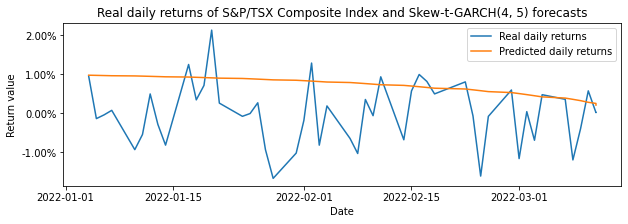

In [ ]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(111)
plot1 = ax.plot(daily_return_last['Date'], daily_return_last['Daily return'] * 100, label='Real daily returns')
plot2 = ax.plot(daily_return_last['Date'], skewtgarch_predictions.variance.values[-1, :], label='Predicted daily returns')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Date')
plt.ylabel('Return value')
plt.title('Real daily returns of S&P/TSX Composite Index and Skew-t-GARCH(4, 5) forecasts')
plt.legend()
plt.show()

На графике видно, что значения предсказываются уже гораздо лучше, однако все равно далеко не идеально. Для лучшего понимания, добились ли мы успеха, можно посмотреть, для какого число дней был предсказан верный знак доходности (то есть будет она отрицательной или положительной), потому что саму доходность, которая является дробным числом с большим количеством знаков после запятой и содержит в себе нелинейные закономерности, как мы уже выяснили раньше, предсказывать все же непросто, из чего можно сделать вывод, что, возможно, нам и не стоит требовать от модели предсказывать доходности с точностью до какого-то определенного знака после запятой.

In [ ]:
round((np.sign(daily_return_last['Daily return']) == np.sign(skewtgarch_predictions.variance.values[-1, :])).sum() / daily_return_last['Daily return'].shape[0], 2)

0.51

Мы предсказали с точностью до знака 51% значений доходностей, что является неплохим результатом.

Попробуем увеличить для лучшей модели число лагов $L_1$ и $L_2$ и обучим ее на данных только за 2021 год

In [ ]:
def best_model(func='ARCH', p=5, q=1, dist='normal'):
    best_llh = - np.inf
    best_order = None
    best_arch = None

    pp = range(1, p + 1)
    qq = range(1, q + 1)
    for p in pp:
        for q in qq:
            try:
                arch = arch_model( daily_return[daily_return['Date'].dt.year > 2020]['Daily return'] * 100,
                                  mean='Zero', vol=func, p=p, q=q, dist=dist)
                arch = arch.fit()
                arch_llh = arch.loglikelihood
                if arch_llh > best_llh:
                    best_llh = arch_llh
                    best_order = (p, q)
                    best_arch = arch
            except: continue


    print('log-likelihood: %6.2f | (p, q): %s'%(best_llh, best_order))
    return best_arch





skewtgarch2 = best_model(func='GARCH', p=20, q=20, dist='skewt')

Выходные данные были обрезаны до нескольких последних строк (5000).
Iteration:     24,   Func. Count:    827,   Neg. LLF: 234.62629512281825
Iteration:     25,   Func. Count:    861,   Neg. LLF: 234.6262509794507
Iteration:     26,   Func. Count:    896,   Neg. LLF: 234.62623816957736
Iteration:     27,   Func. Count:    930,   Neg. LLF: 234.62623544208657
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 234.6262349000463
            Iterations: 27
            Function evaluations: 934
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     35,   Neg. LLF: 247.2069987195193
Iteration:      2,   Func. Count:     71,   Neg. LLF: 242.88935496442446
Iteration:      3,   Func. Count:    107,   Neg. LLF: 240.7592431934341
Iteration:      4,   Func. Count:    143,   Neg. LLF: 240.33718044401144
Iteration:      5,   Func. Count:    179,   Neg. LLF: 237.5463054114689
Iteration:      6,   Func. Count:    215,   Neg. LLF: 236.9758357863

In [ ]:
skewtgarch2_predictions = skewtgarch2.forecast(horizon=daily_return_last.shape[0])

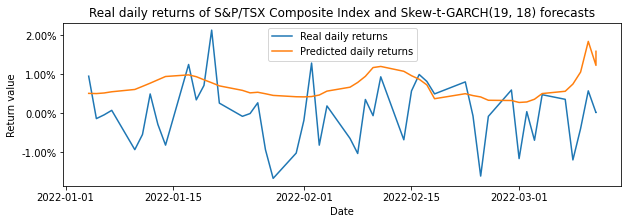

In [ ]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(111)
plot1 = ax.plot(daily_return_last['Date'], daily_return_last['Daily return'] * 100, label='Real daily returns')
plot2 = ax.plot(daily_return_last['Date'], skewtgarch2_predictions.variance.values[-1, :], label='Predicted daily returns')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel('Date')
plt.ylabel('Return value')
plt.title('Real daily returns of S&P/TSX Composite Index and Skew-t-GARCH(19, 18) forecasts')
plt.legend()
plt.show()

Можно увидеть, что модель не стала предсказывать доходности значительно лучше, однако ее график все же приблизился к истинному, а это значит, что мы добились еще лучшего результата.

## **Заключение**

Итак, мы проанализировали ряд доходностей канадского индекса S&P/TSX и посмотрели на предсказания будущих значений этого ряда, для получения которых обучили несколько статистических моделей.

Таким образом, мы достигли поставленных целей, подробно изучив выбранный нами финансовый ряд и применив к нему знания, полученные во время прохождения курса "Анализ и прогнозирование финансовых рисков".